### FindMarkers on Glomeruli

Main Figure 4 and corresponding supplemental figures are generated

Author: Pierre Isnard, Dian Li, Haojia Wu

Contact: dianli@wustl.edu

Last updated: December 7, 2023

In [1]:
suppressMessages(library(Seurat))
suppressMessages(library(ggplot2))
suppressMessages(library(reshape2))
suppressMessages(library(EnhancedVolcano))
suppressMessages(library(dplyr))

suppressMessages(library(ComplexHeatmap))
suppressMessages(library(dichromat))
suppressMessages(library(RColorBrewer))

suppressMessages(library(scales))

In [2]:
plots_path_main = "../../plots/version_1/main_figures"
plots_path_supp = "../../plots/version_1/supp_figures"
processed_data_path = "../../processed_data/version_1/FindMarkers"

dir.create(plots_path_main, showWarnings = F, recursive = T)
dir.create(plots_path_supp, showWarnings = F, recursive = T)
dir.create(processed_data_path, showWarnings = F, recursive = T)

In [3]:
color_palette_glom = c("#fff088", 
                         "#c3ab00",
                         "#615500")
names(color_palette_glom) = c("DKDG",
                             "SGS",
                             "GGS")

### Step 1. Load dkd1 Seurat object generated from Figure 1

In [4]:
load("../../processed_data/version_1/dkd1_umap.RData")

In [5]:
load("../../meta/meta_info.RData")

#### Step 1.2. load Glomeruli meta data

In [6]:
glom_meta<-read.csv("../../meta/spots_selection - dkd_glom_v2_1.csv")

In [7]:
dkd1
dim(glom_meta)
head(glom_meta)

An object of class Seurat 
36131 features across 2802 samples within 2 assays 
Active assay: SCT (18046 features, 3000 variable features)
 1 other assay present: Spatial
 2 dimensional reductions calculated: pca, umap
 1 image present: slice1

[1] 345   3

,Barcode,Glomeruli_ID,Glom.classification
,<chr>,<chr>,<chr>
1,CATCGGCATGTCGAAG-1,G2,DKDG
2,CCATGAACAATGCTCC-1,G2,DKDG
3,TGTACCACATACTGGT-1,G2,DKDG
4,CGAGCGTAATGGAGTG-1,G3,DKDG
5,CTGTGGTAAGCTAATA-1,G3,DKDG
6,TACACCTTGCGGCAGG-1,G3,DKDG


#### Step 1.3. export dkd1 glom related meta table for CellScopes use

In [8]:
df_meta_glom = glom_meta
colnames(df_meta_glom) = c("barcode", "glom_id", "glom_class")
rownames(df_meta_glom) = df_meta_glom$barcode

df_meta = data.frame("barcode" = dkd1$Barcode)
df_meta$glom_id = "none"
df_meta$glom_class = "none"

df_meta[df_meta_glom$barcode, "glom_id"] = df_meta_glom$glom_id
df_meta[df_meta_glom$barcode, "glom_class"] = df_meta_glom$glom_class

write.csv(df_meta, "../../meta/subclusters_glomeruli.csv", row.names = F)

### Step 2. Subset object to glom only 

In [9]:
dkd1_glom <- subset(dkd1, cells = glom_meta$Barcode)
dkd1_glom

An object of class Seurat 
36131 features across 345 samples within 2 assays 
Active assay: SCT (18046 features, 3000 variable features)
 1 other assay present: Spatial
 2 dimensional reductions calculated: pca, umap
 1 image present: slice1

#### Step 2.1. update meta data with glom class

In [10]:
meta_tmp = dkd1_glom@meta.data
meta_tmp$glom_id = NULL
meta_tmp$glom_class = NULL

meta_tmp[df_meta_glom$barcode, c("glom_id", "glom_class")] = df_meta_glom[, c("glom_id", "glom_class")]

dkd1_glom@meta.data = meta_tmp

In [11]:
dkd1_glom$glom_class = factor(dkd1_glom$glom_class, levels = c("DKDG", "SGS", "GGS"))

### Step 3. Generate UMAP for spots annotated as glomeruli

In [12]:
dkd1_glom <- SCTransform(dkd1_glom, assay = "Spatial", verbose = FALSE)
dkd1_glom <- RunPCA(dkd1_glom, assay = "SCT", verbose = FALSE)
dkd1_glom <- FindNeighbors(dkd1_glom, reduction = "pca", dims = 1:20)
dkd1_glom <- FindClusters(dkd1_glom, verbose = FALSE, resolution = 0.6)
dkd1_glom <- RunUMAP(dkd1_glom, reduction = "pca", dims = 1:20, min.dist = 0.1)

Computing nearest neighbor graph

Computing SNN

Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”
20:58:09 UMAP embedding parameters a = 1.577 b = 0.8951

20:58:09 Read 345 rows and found 20 numeric columns

20:58:09 Using Annoy for neighbor search, n_neighbors = 30

20:58:09 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

20:58:09 Writing NN index file to temp file /tmp/RtmpZyt6Nc/file3776427a0f6797

20:58:09 Searching Annoy index using 1 thread, search_k = 3000

20:58:09 Annoy recall = 100%

20:58:10 Commencing smooth kNN distance cal

In [13]:
custom_theme <- theme(text = element_text(family = "Helvetica"))

empty_theme = theme(axis.line=element_blank(),
      axis.text.x=element_blank(),
      axis.text.y=element_blank(),
      axis.ticks=element_blank(),
      axis.title.x=element_blank(),
      axis.title.y=element_blank())

# color code is from: https://icolorpalette.com/color/golden-yellow#google_vignette

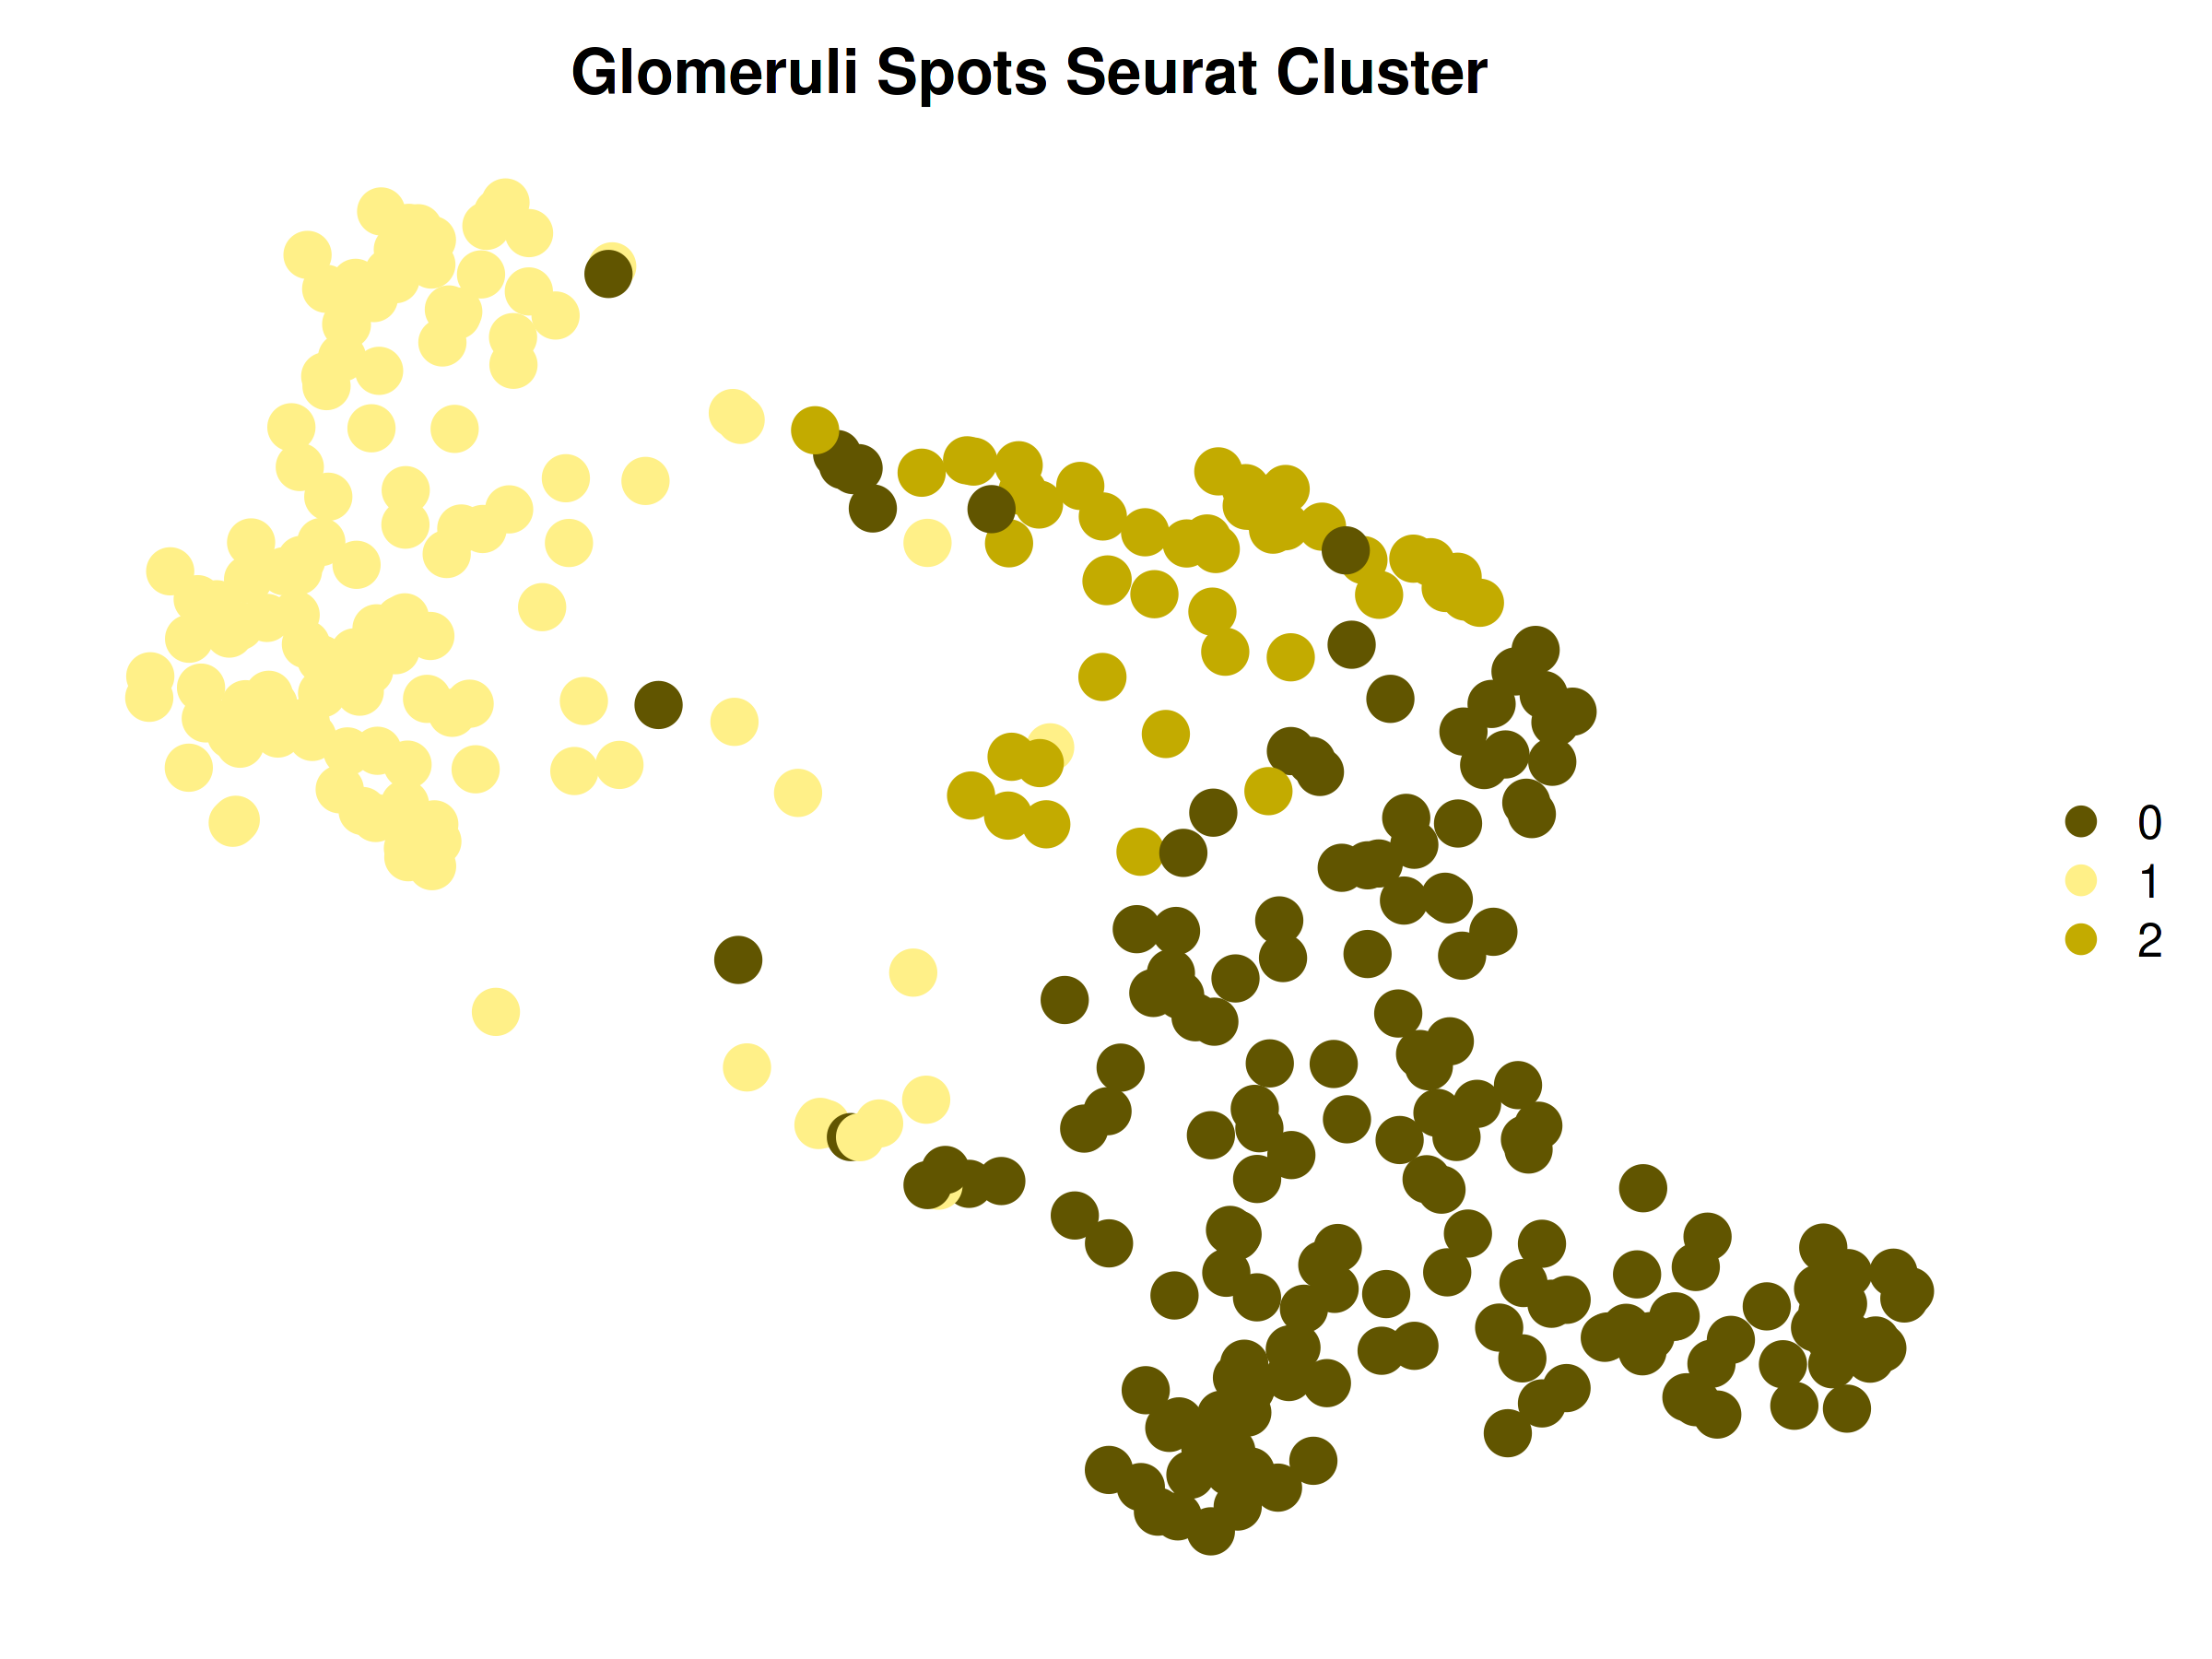

In [14]:
options(repr.plot.width = 8, repr.plot.height = 6, repr.plot.res = 300)
p = DimPlot(dkd1_glom, group.by = "seurat_clusters", raster = FALSE, pt.size = 5, 
            cols = c("#615500", 
                     "#fff088",
                     "#c3ab00")
           ) + ggtitle(label = "Glomeruli Spots Seurat Cluster")
p = p + empty_theme + custom_theme
p

ggsave(file.path(plots_path_main, "Dimplot_glom_seurat_cluster.png"), plot = p, width = 8, height = 6, units = "in", dpi = 300)
ggsave(file.path(plots_path_main, "Dimplot_glom_seurat_cluster.pdf"), plot = p, width = 8, height = 6, units = "in", dpi = 300)
ggsave(file.path(plots_path_main, "Dimplot_glom_seurat_cluster.svg"), plot = p, width = 8, height = 6, units = "in", dpi = 300)

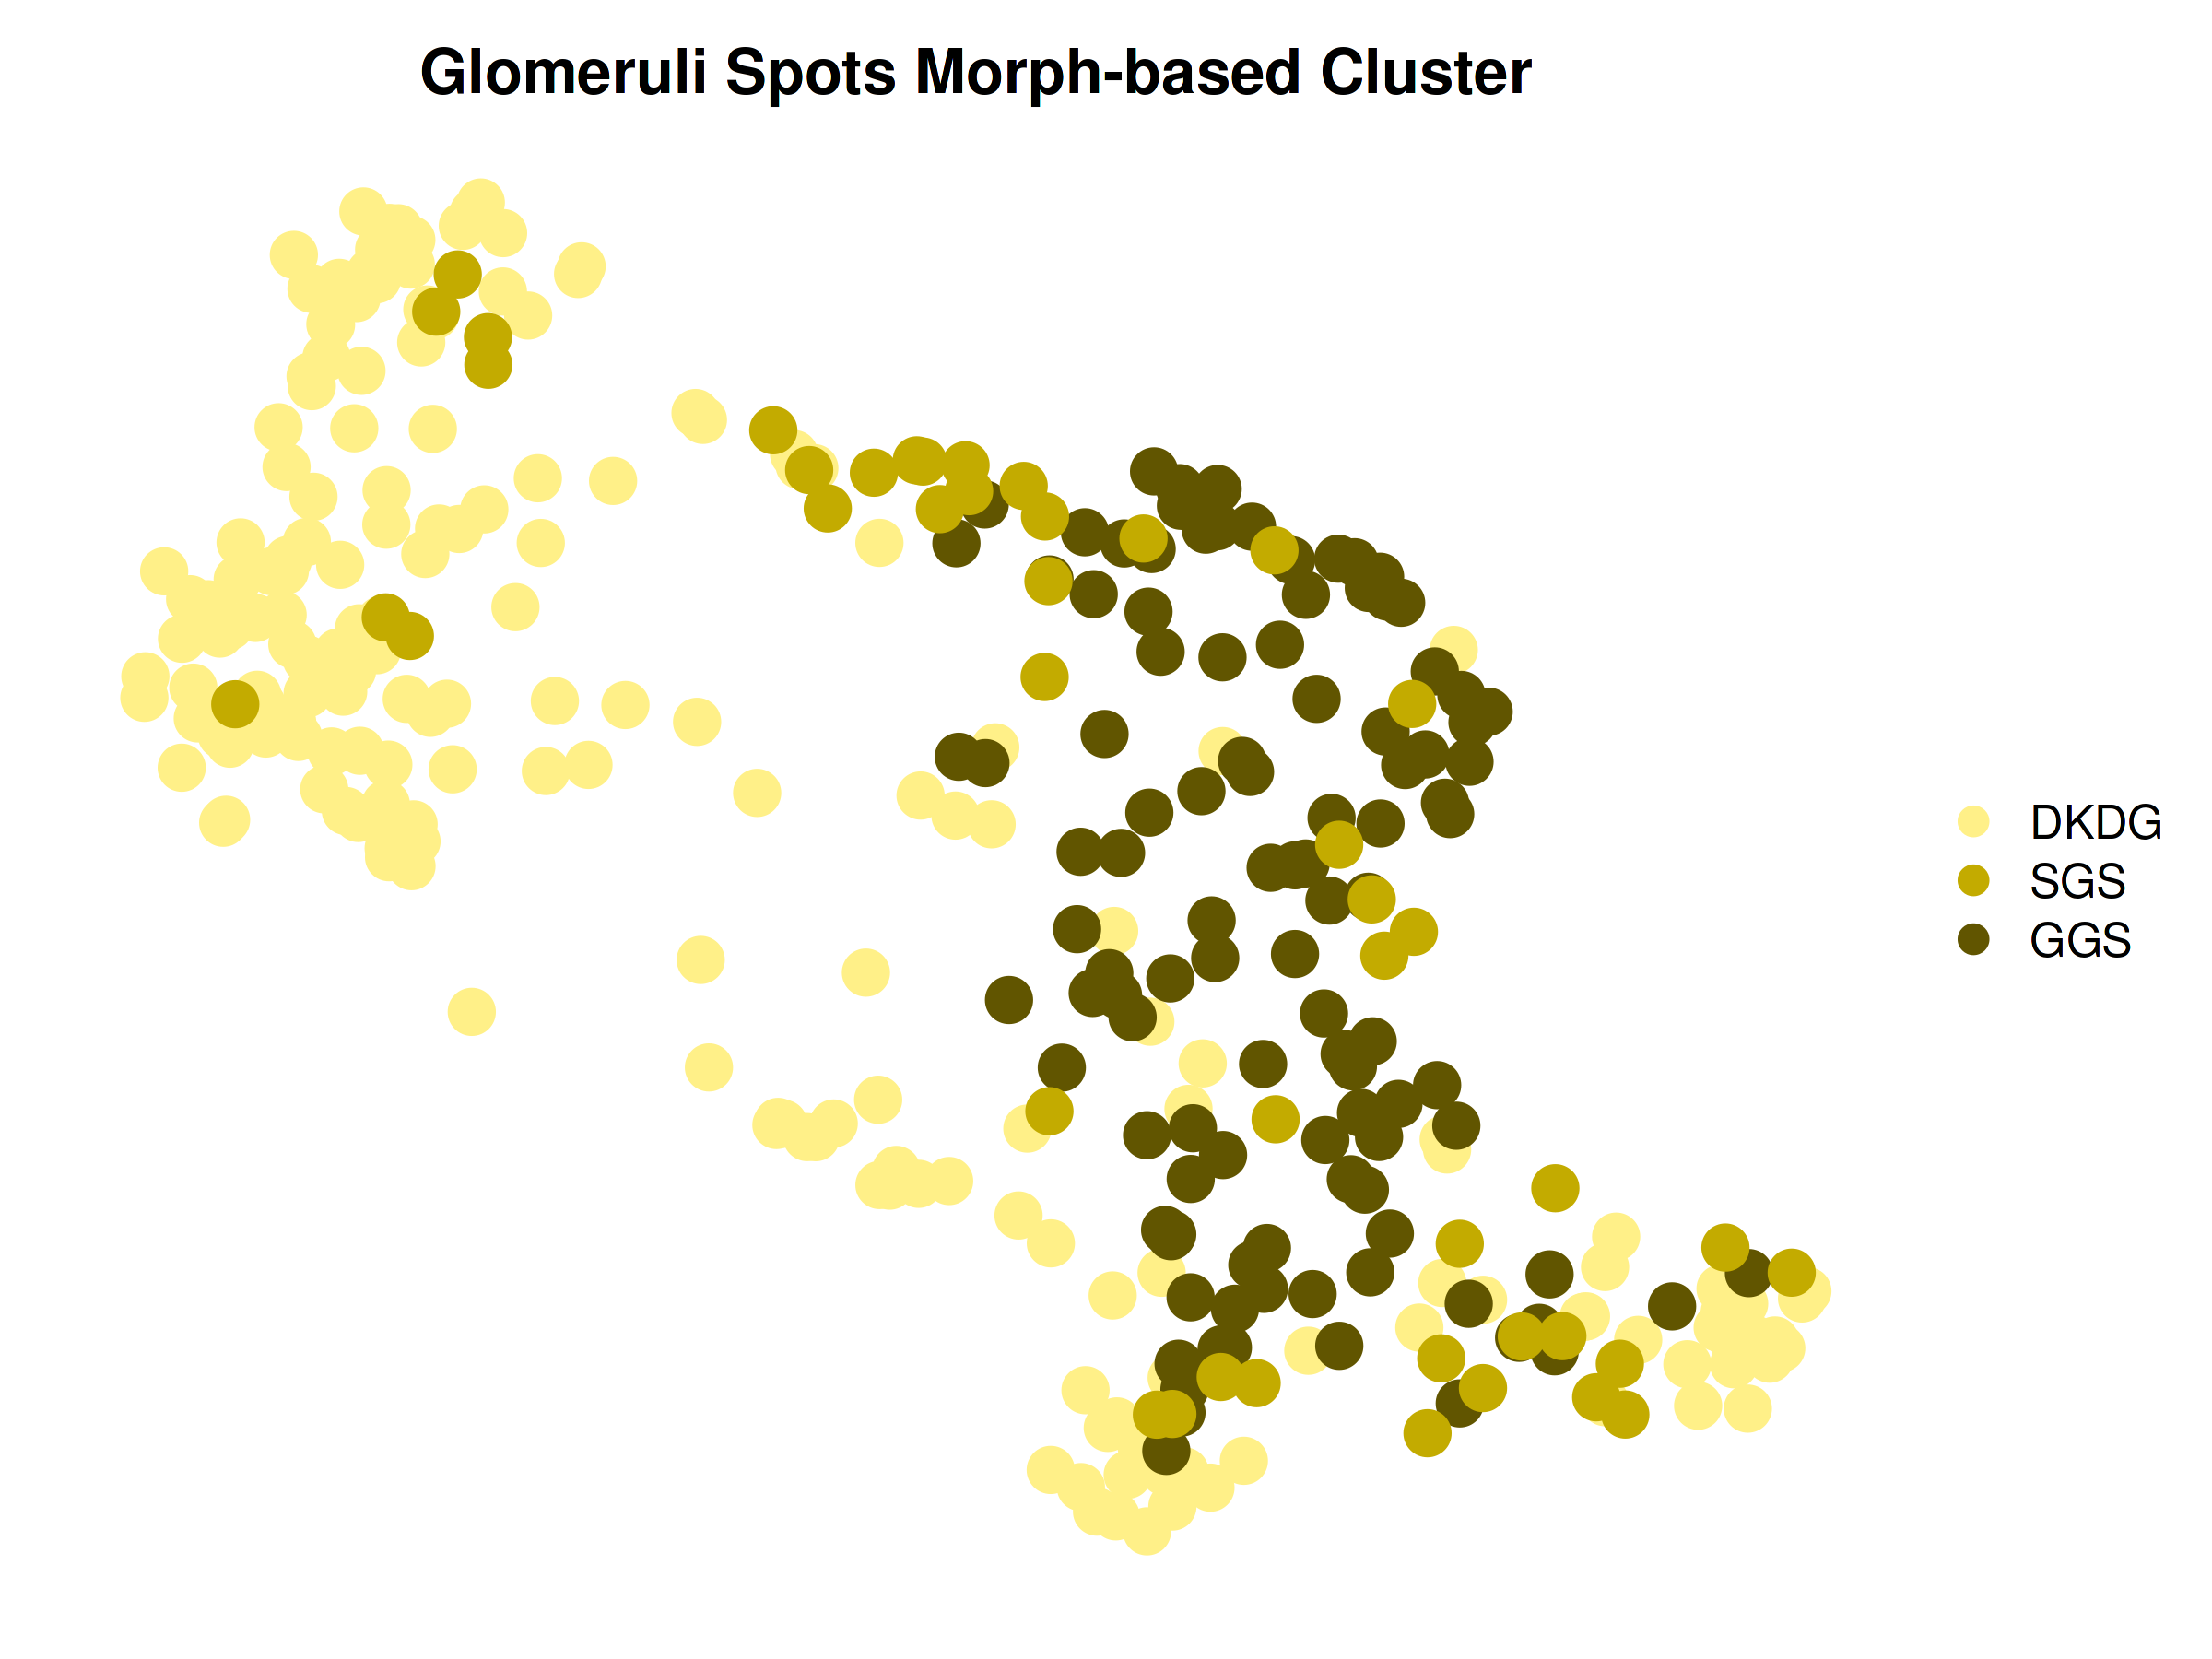

In [15]:
options(repr.plot.width = 8, repr.plot.height = 6, repr.plot.res = 300)

p = DimPlot(dkd1_glom, group.by = "glom_class", raster = FALSE, pt.size = 5, 
            cols = color_palette_glom
           ) + ggtitle(label = "Glomeruli Spots Morph-based Cluster")
p = p + empty_theme + custom_theme
p

ggsave(file.path(plots_path_main, "Dimplot_glom_morph_class.png"), plot = p, width = 8, height = 6, units = "in", dpi = 300)
ggsave(file.path(plots_path_main, "Dimplot_glom_morph_class.pdf"), plot = p, width = 8, height = 6, units = "in", dpi = 300)
ggsave(file.path(plots_path_main, "Dimplot_glom_morph_class.svg"), plot = p, width = 8, height = 6, units = "in", dpi = 300)

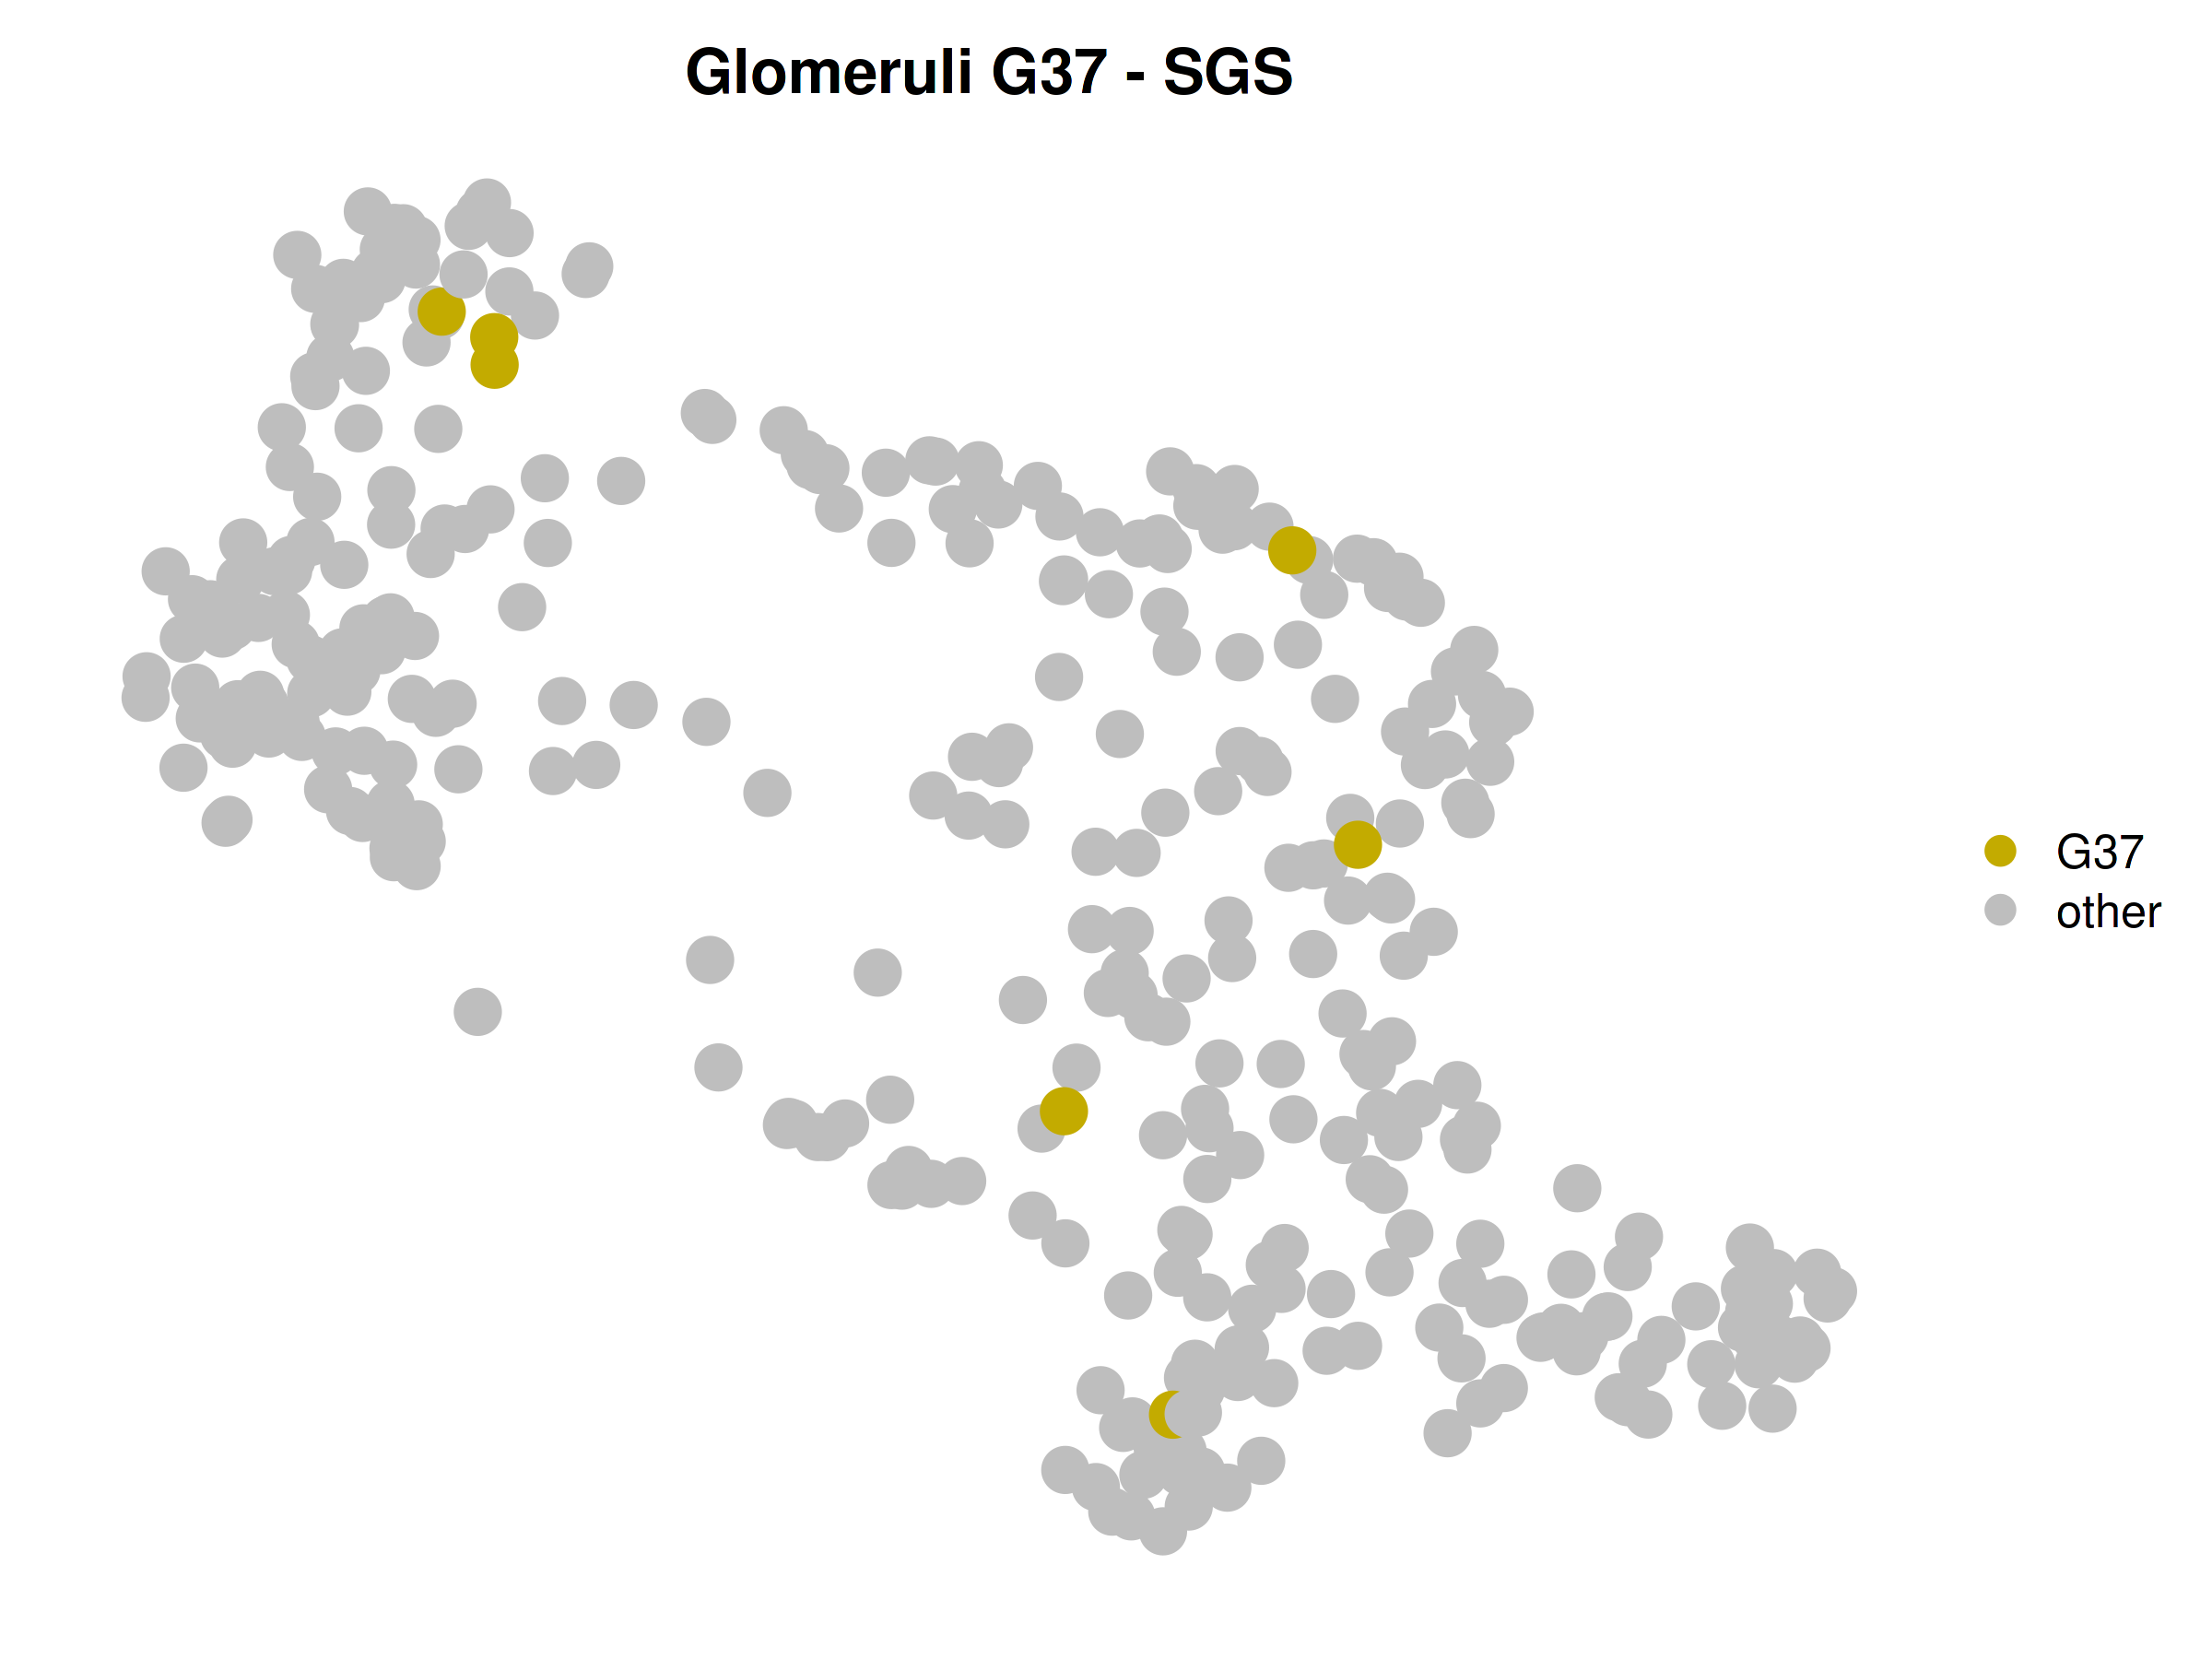

In [16]:
dkd1_glom$glom_id2 = dkd1_glom$glom_id
dkd1_glom$glom_id2[dkd1_glom$glom_id2 != "G37"] = "other"

options(repr.plot.width = 8, repr.plot.height = 6, repr.plot.res = 300)

color_temp = c("#c3ab00", "grey")
names(color_temp) = c("G37", "other")
p = DimPlot(dkd1_glom, group.by = "glom_id2", raster = FALSE, pt.size = 5, 
            cols = color_temp
           ) + ggtitle(label = "Glomeruli G37 - SGS")
p = p + empty_theme + custom_theme
p

ggsave(file.path(plots_path_supp, "Dimplot_glom_G37.png"), plot = p, width = 8, height = 6, units = "in", dpi = 300)
ggsave(file.path(plots_path_supp, "Dimplot_glom_G37.pdf"), plot = p, width = 8, height = 6, units = "in", dpi = 300)
ggsave(file.path(plots_path_supp, "Dimplot_glom_G37.svg"), plot = p, width = 8, height = 6, units = "in", dpi = 300)

#### Export G37 id for CellScope visualization

In [22]:
meta_tmp = dkd1_glom@meta.data[, c("Barcode", "glom_id2")]
write.csv(meta_tmp, "../../meta/subclusters_glomeruli_G37.csv", row.names = F)

### Step 4. Compare Seurat clusters with Morph-based glomeruli class

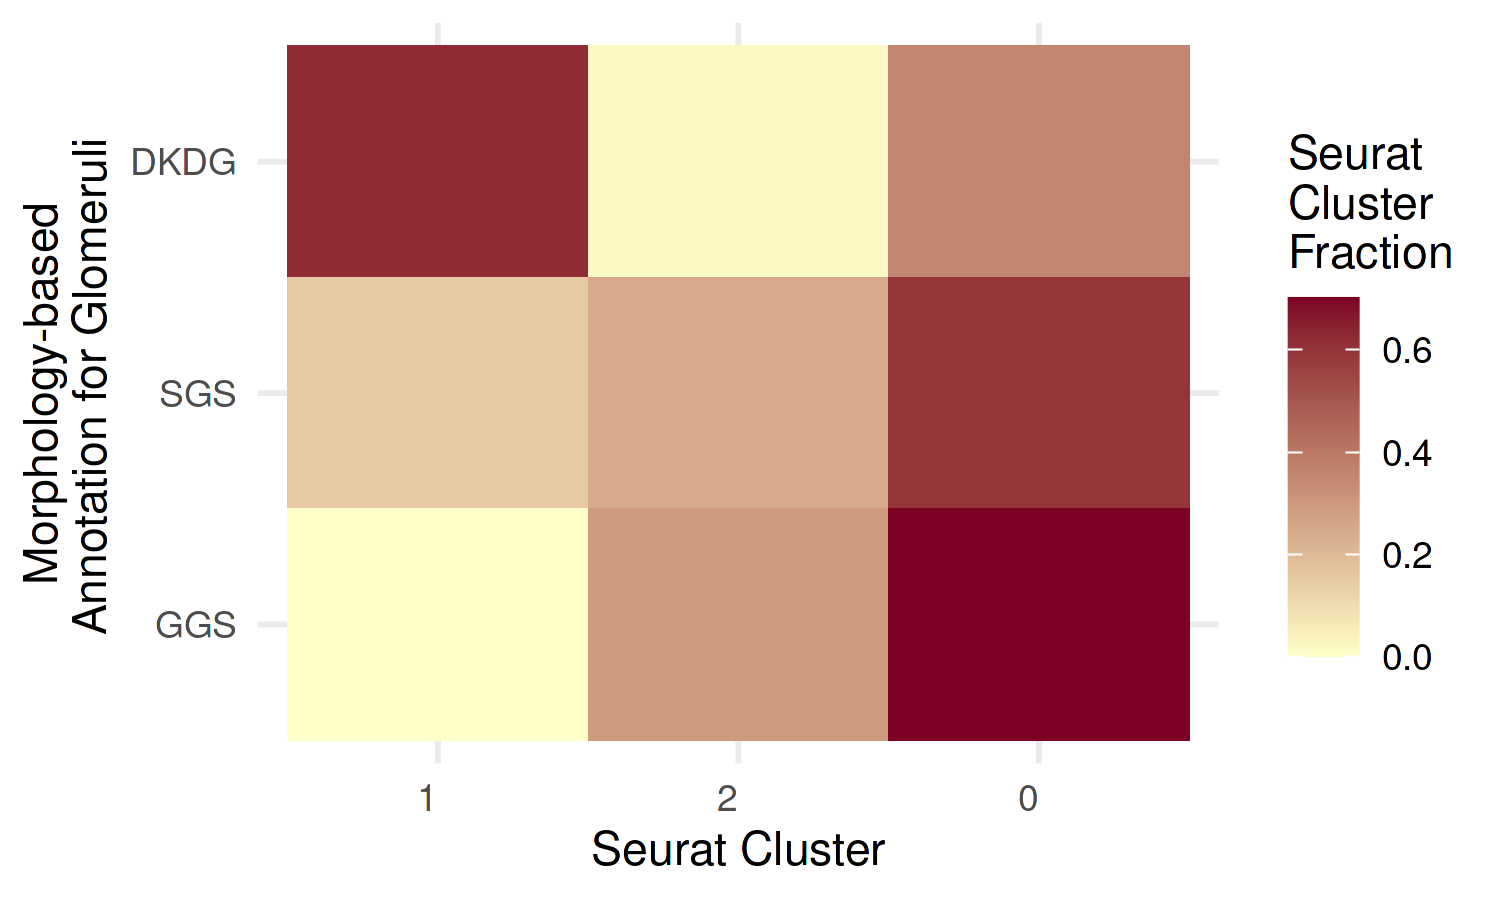

In [16]:
prediction <- table(dkd1_glom$seurat_clusters, dkd1_glom$glom_class)
prediction <- t(t(prediction)/colSums(prediction))  # normalize for number of cells in each cell type

# Reorder rows manually
prediction_reordered <- prediction[
    c(2,3,1),
]

prediction_long <- melt(prediction_reordered)

prediction_long$Var1 = factor(x = prediction_long$Var1, levels = prediction_long$Var1[1:3])
prediction_long$Var2 <- factor(prediction_long$Var2, levels = rev(unique(prediction_long$Var2)))

options(repr.plot.width = 5, repr.plot.height = 3, repr.plot.res = 300)

p = ggplot(prediction_long, aes(Var1, Var2, fill = value)) + 
    geom_tile() +
    scale_fill_gradient(name = "Seurat\nCluster\nFraction",low = "#ffffc8", high = "#7d0025") +

    theme_minimal() +
    labs(x = "Column", y = "Row", fill = "Value") +
    theme(axis.text.x = element_text(angle = 0, hjust = 1)) + 
    xlab("Seurat Cluster") + 
    ylab("Morphology-based\n Annotation for Glomeruli") +
    custom_theme

p

ggsave(p, filename = file.path(plots_path_supp, "Heatmap_glom_Morph_based_vs_Seurat_cluster.png"), width = 5, height = 3, units = "in", dpi = 300)
ggsave(p, filename = file.path(plots_path_supp, "Heatmap_glom_Morph_based_vs_Seurat_cluster.pdf"), width = 5, height = 3, units = "in", dpi = 300)
ggsave(p, filename = file.path(plots_path_supp, "Heatmap_glom_Morph_based_vs_Seurat_cluster.svg"), width = 5, height = 3, units = "in", dpi = 300)


### Step 5. Create averaged glomeruli object, as in the glom_id column of df_meta_glom

In [17]:
Idents(dkd1_glom) = 'glom_id'

In [18]:
dkd1_glom_avg <- AverageExpression(dkd1_glom, assays = "Spatial", slot="counts",return.seurat = T)

In [19]:
dkd1_glom_avg

An object of class Seurat 
18085 features across 82 samples within 1 assay 
Active assay: Spatial (18085 features, 0 variable features)

In [20]:
dkd1_glom_avg$glom_id = rownames(dkd1_glom_avg@meta.data)

In [21]:
df_meta_glom_sub = df_meta_glom[, c("glom_id", "glom_class")]

In [22]:
meta_tmp = dkd1_glom_avg@meta.data
meta_tmp = left_join(meta_tmp, distinct(df_meta_glom_sub), by = "glom_id")
rownames(meta_tmp) = meta_tmp$glom_id

dkd1_glom_avg@meta.data = meta_tmp

In [23]:
dkd1_glom_avg$glom_class = factor(dkd1_glom_avg$glom_class, levels = c("DKDG", "SGS", "GGS"))

In [24]:
head(dkd1_glom_avg, 5)

,orig.ident,nCount_Spatial,nFeature_Spatial,glom_id,glom_class
,<fct>,<dbl>,<int>,<chr>,<fct>
G2,Average,7699.333,8260,G2,DKDG
G3,Average,10356.667,9227,G3,DKDG
G5,Average,10821.000,9211,G5,DKDG
G6,Average,6700.000,4259,G6,DKDG
G9,Average,14804.600,11730,G9,DKDG


In [25]:
dkd1_glom_avg <- NormalizeData(dkd1_glom_avg, assay = "Spatial", verbose = FALSE)
dkd1_glom_avg <- FindVariableFeatures(dkd1_glom_avg, selection.method = "vst", nfeatures = 2000)
all.genes <- rownames(dkd1_glom_avg)
dkd1_glom_avg <- ScaleData(dkd1_glom_avg, features = all.genes)

Centering and scaling data matrix



In [26]:
dkd1_glom_avg <- RunPCA(dkd1_glom_avg, verbose = FALSE)
dkd1_glom_avg <- FindNeighbors(dkd1_glom_avg, reduction = "pca", dims = 1:20)
dkd1_glom_avg <- FindClusters(dkd1_glom_avg, verbose = FALSE, resolution = 1.1)
dkd1_glom_avg <- RunUMAP(dkd1_glom_avg, reduction = "pca", dims = 1:20, min.dist = 0.1)

Warning message in irlba(A = t(x = object), nv = npcs, ...):
“You're computing too large a percentage of total singular values, use a standard svd instead.”
Computing nearest neighbor graph

Computing SNN

16:59:41 UMAP embedding parameters a = 1.577 b = 0.8951

16:59:41 Read 82 rows and found 20 numeric columns

16:59:41 Using Annoy for neighbor search, n_neighbors = 30

16:59:41 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

16:59:41 Writing NN index file to temp file /tmp/RtmpiDUVXm/file2baaaa7b96d909

16:59:41 Searching Annoy index using 1 thread, search_k = 3000

16:59:41 Annoy recall = 100%

16:59:42 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbors = 30

16:59:43 Initializing from normalized Laplacian + noise (using irlba)

16:5

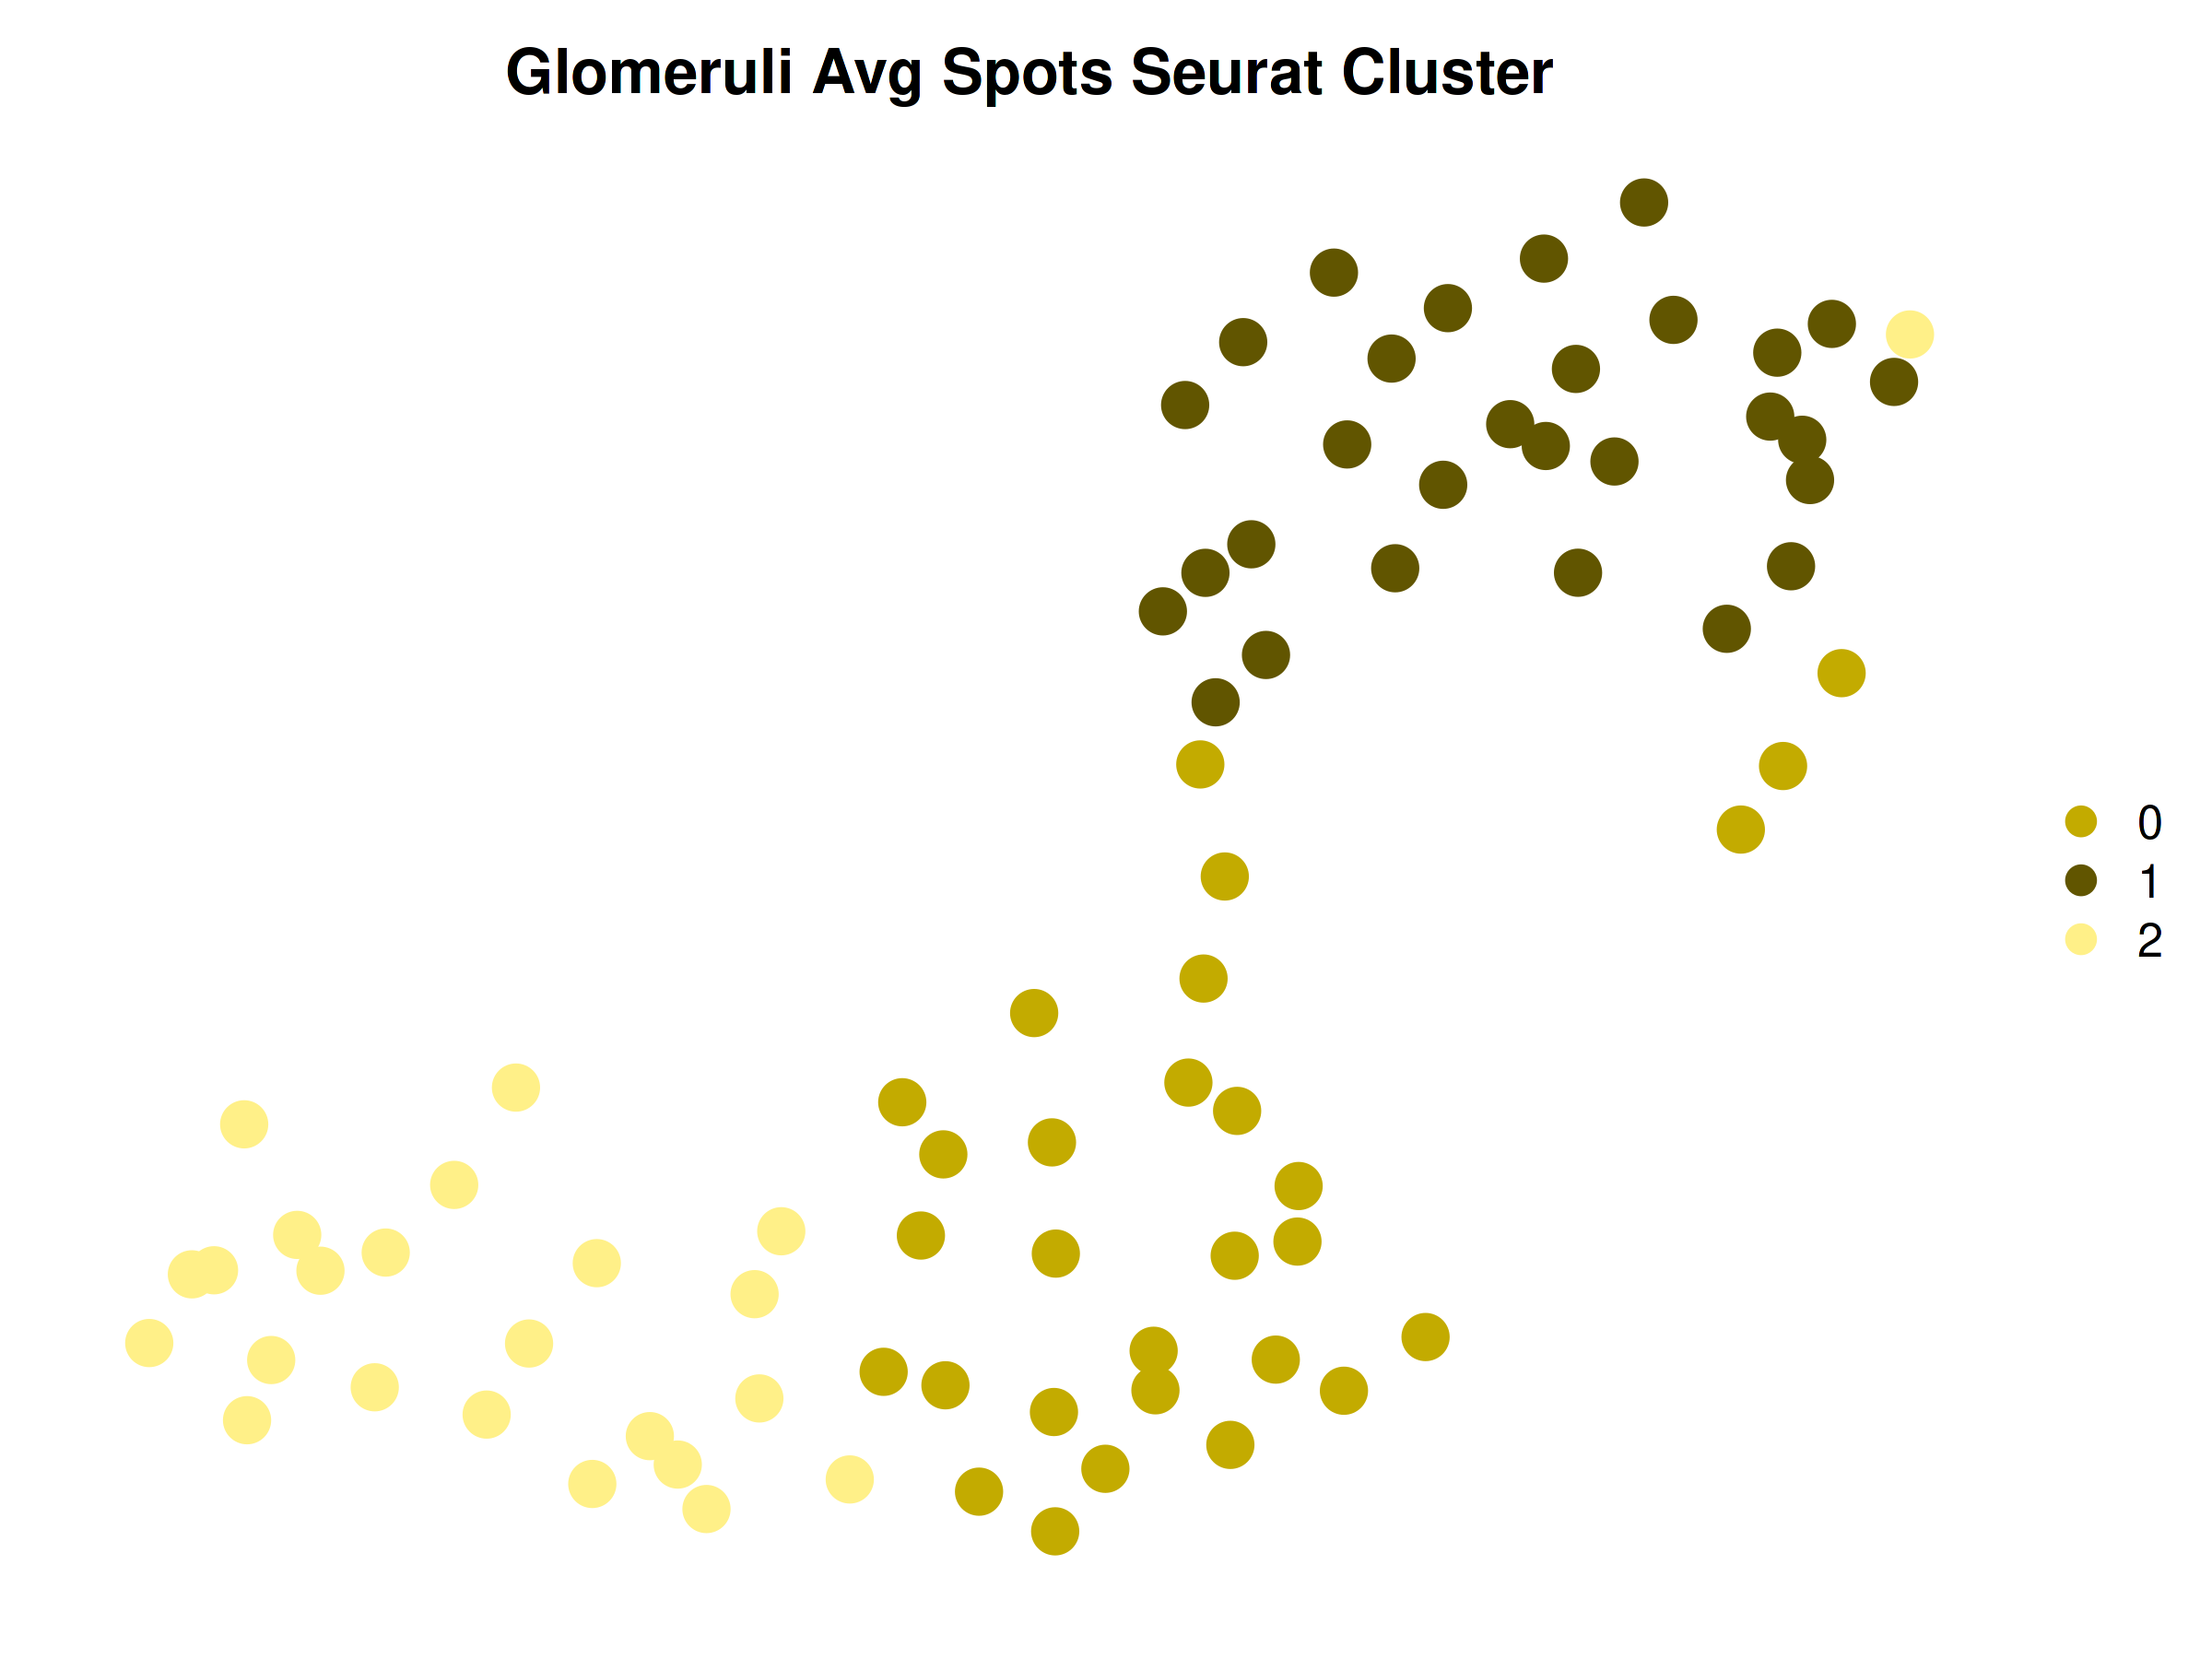

In [27]:
options(repr.plot.width = 8, repr.plot.height = 6, repr.plot.res = 300)
p = DimPlot(dkd1_glom_avg, group.by = "seurat_clusters", raster = FALSE, pt.size = 5, 
            cols = c("#c3ab00", 
                     "#615500",
                     "#fff088")
           ) + ggtitle(label = "Glomeruli Avg Spots Seurat Cluster")
p = p + empty_theme + custom_theme
p

ggsave(file.path(plots_path_main, "Dimplot_glom_avg_seurat_cluster.png"), plot = p, width = 8, height = 6, units = "in", dpi = 300)
ggsave(file.path(plots_path_main, "Dimplot_glom_avg_seurat_cluster.pdf"), plot = p, width = 8, height = 6, units = "in", dpi = 300)
ggsave(file.path(plots_path_main, "Dimplot_glom_avg_seurat_cluster.svg"), plot = p, width = 8, height = 6, units = "in", dpi = 300)

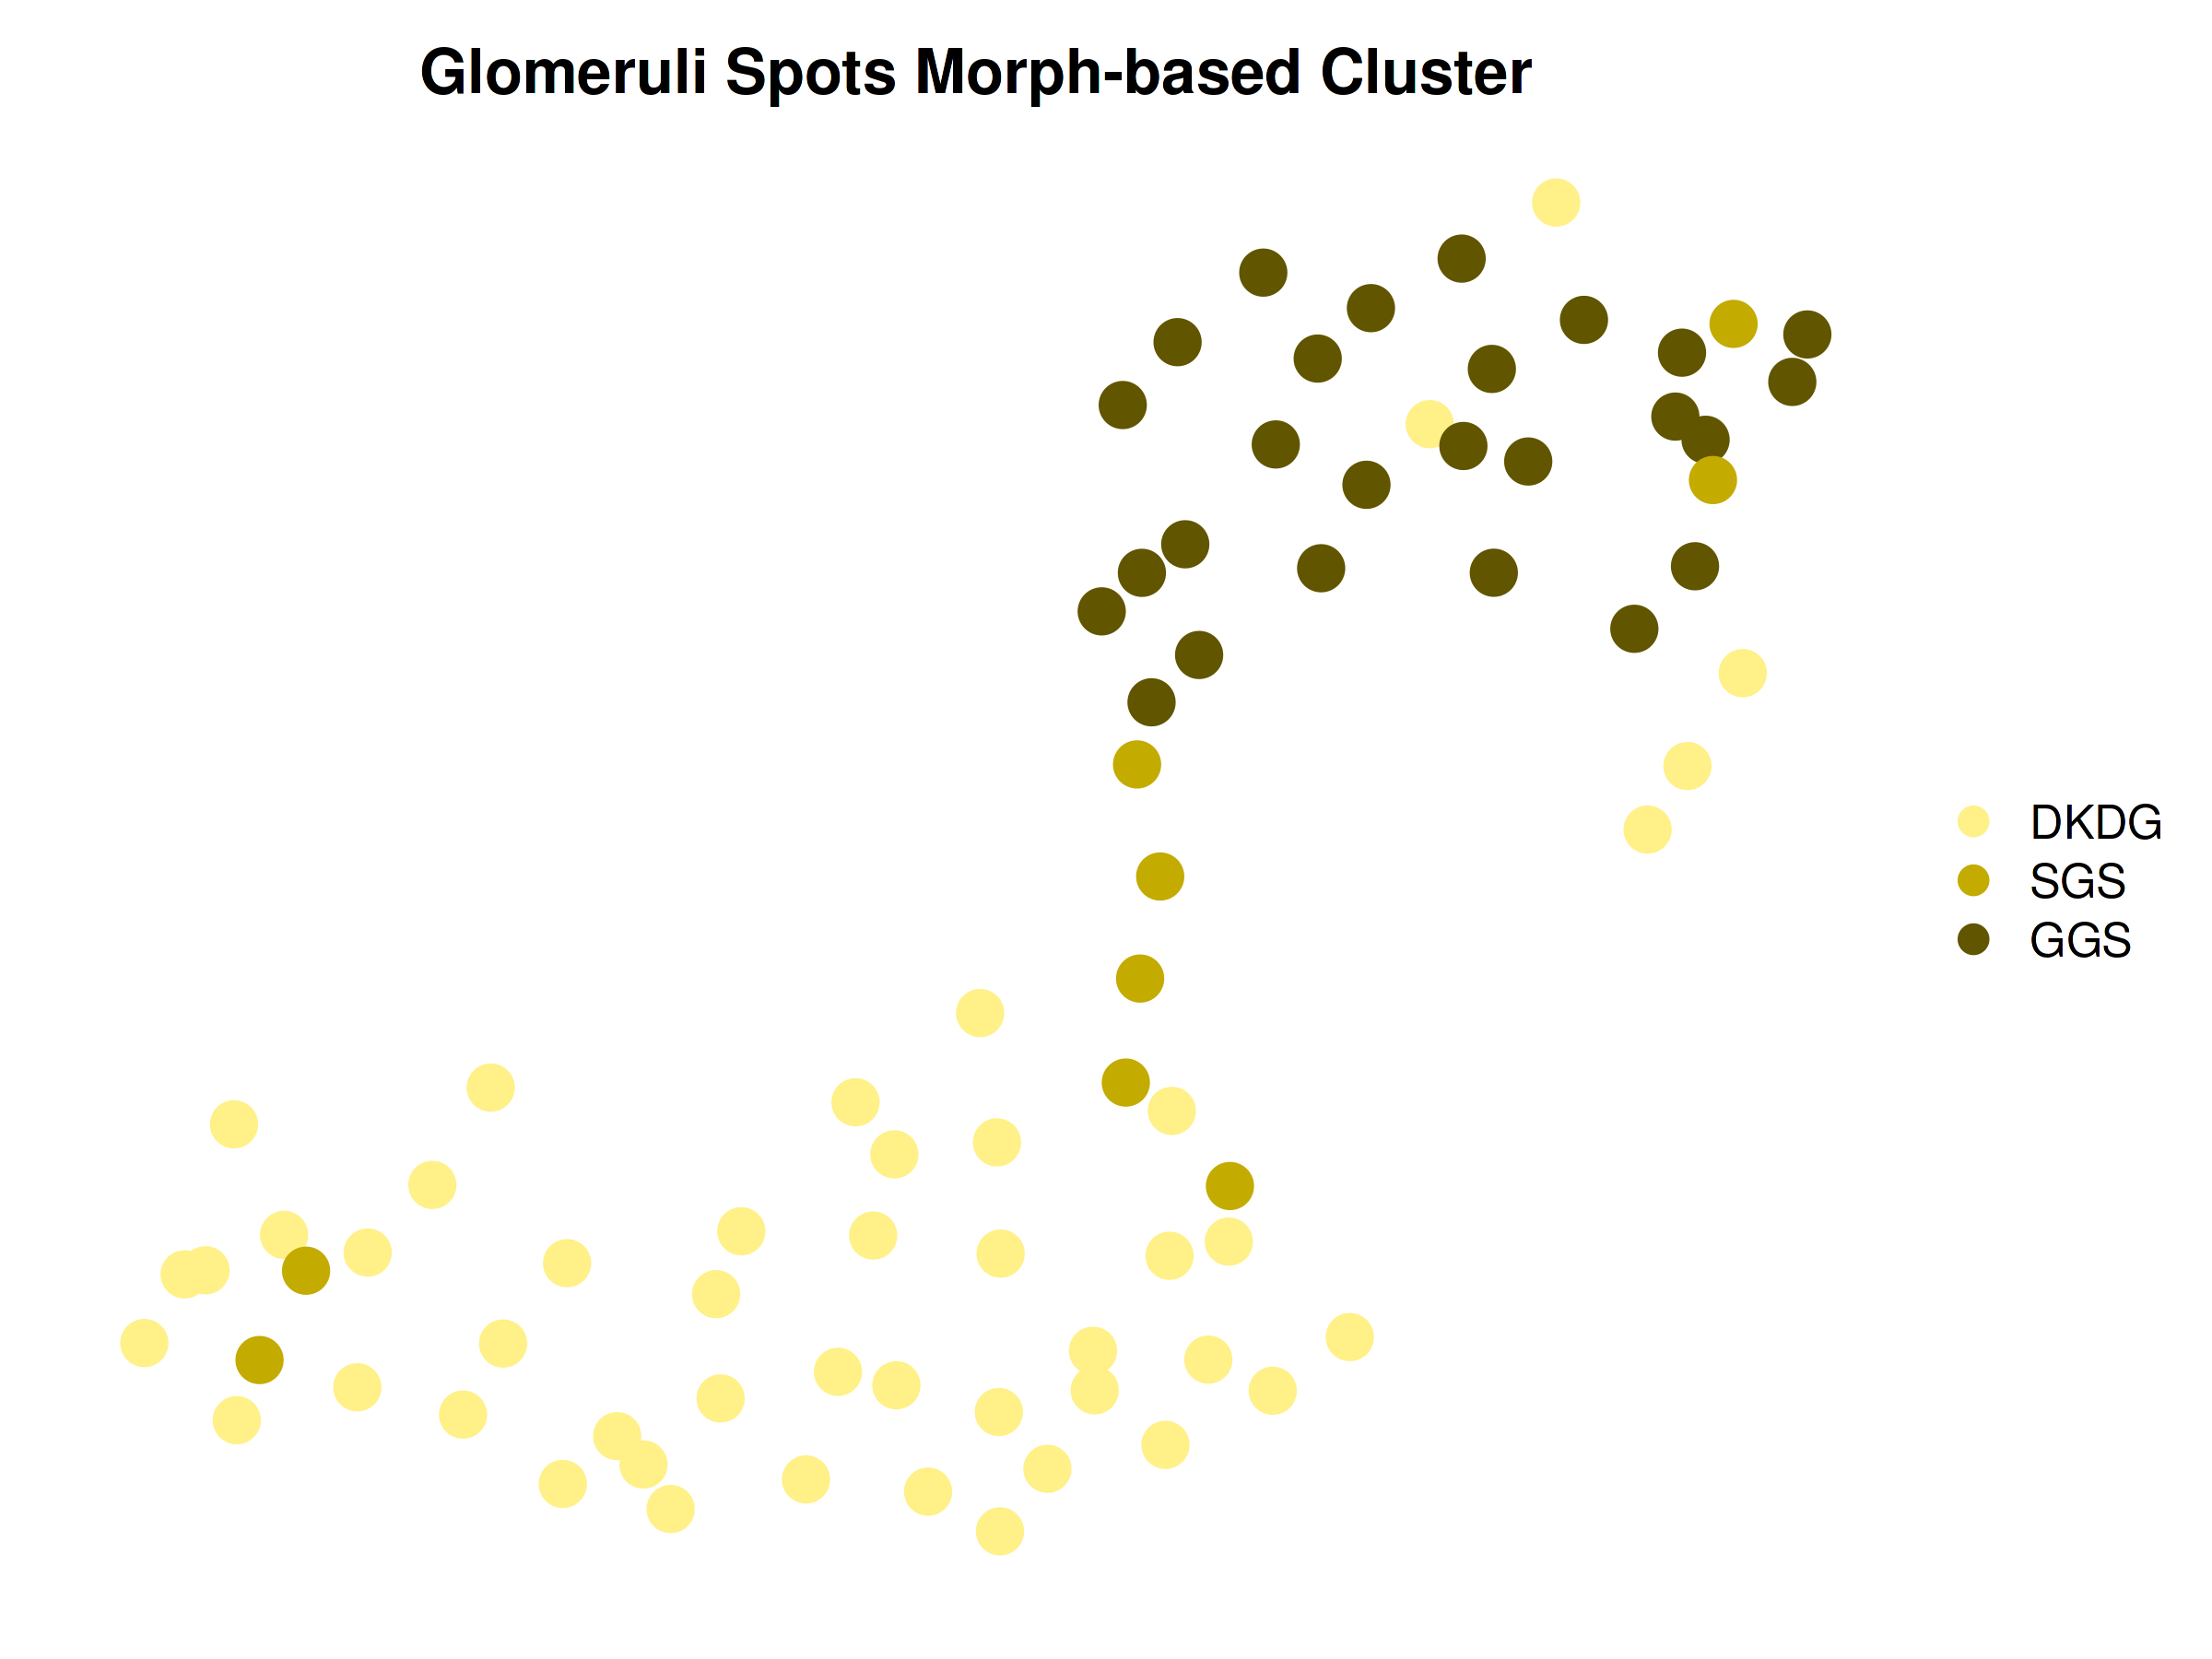

In [28]:
options(repr.plot.width = 8, repr.plot.height = 6, repr.plot.res = 300)

p = DimPlot(dkd1_glom_avg, group.by = "glom_class", raster = FALSE, pt.size = 5, 
            cols = color_palette_glom
           ) + ggtitle(label = "Glomeruli Spots Morph-based Cluster")
p = p + empty_theme + custom_theme
p

ggsave(file.path(plots_path_main, "Dimplot_glom_avg_morph_class.png"), plot = p, width = 8, height = 6, units = "in", dpi = 300)
ggsave(file.path(plots_path_main, "Dimplot_glom_avg_morph_class.pdf"), plot = p, width = 8, height = 6, units = "in", dpi = 300)
ggsave(file.path(plots_path_main, "Dimplot_glom_avg_morph_class.svg"), plot = p, width = 8, height = 6, units = "in", dpi = 300)

#### Step5.2. save dkd1_glom_avg object for downstream analysis

In [29]:
saveRDS(dkd1_glom_avg, file = "../../processed_data/version_1/dkd1_glom_avg.RDS")

### Step 6. Over representation analysis for glomeruli subclusters with GO BP

In [30]:
Idents(dkd1_glom_avg) = "glom_class"

In [31]:
# find clusters markers Only Positive ones
glom.avg.Pos.markers <- FindAllMarkers(dkd1_glom_avg, only.pos = TRUE, min.pct = 0.1, return.thresh = 0.05)

Calculating cluster DKDG

Calculating cluster SGS

Calculating cluster GGS



In [32]:
dim(glom.avg.Pos.markers)
head(glom.avg.Pos.markers)
write.csv(glom.avg.Pos.markers, file.path(processed_data_path, "glom.avg.Pos.markers.csv"))

[1] 763   7

,p_val,avg_log2FC,pct.1,pct.2,p_val_adj,cluster,gene
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<chr>
PCOLCE2,4.924599e-13,1.3165347,1.000,0.686,8.906137e-09,DKDG,PCOLCE2
VEGFA,7.924414e-13,1.6771746,1.000,1.000,1.433130e-08,DKDG,VEGFA
NDNF,9.827219e-13,1.3556487,0.979,0.800,1.777253e-08,DKDG,NDNF
BCAM,1.041136e-12,0.9830819,1.000,1.000,1.882894e-08,DKDG,BCAM
TNNT2,2.591260e-12,1.0712726,1.000,0.743,4.686294e-08,DKDG,TNNT2
NPHS1,3.866081e-12,1.3808592,1.000,0.743,6.991807e-08,DKDG,NPHS1


In [33]:
# Load the function
suppressMessages(library("gplots"))
suppressMessages(library("clusterProfiler"))
suppressMessages(library("ComplexHeatmap"))
suppressMessages(library(org.Hs.eg.db))

In [34]:
# Change genes name to entrezID
Cluster_df = glom.avg.Pos.markers
cluster_name_list = unique(Cluster_df$cluster)
cluster_name_list

ids_list = lapply(cluster_name_list, FUN = function(x){
  cluster_i <- Cluster_df[Cluster_df$cluster == x, ]
  ids <- bitr(cluster_i$gene, fromType = 'SYMBOL', toType = c('SYMBOL', 'ENTREZID'), OrgDb = 'org.Hs.eg.db')
  ids$ENTREZID
})
names(ids_list) = cluster_name_list

# Enrichment analysis with enrichGO Biological Process (BP)
ck <- compareCluster(geneCluster = ids_list, fun = enrichGO,
                     OrgDb = org.Hs.eg.db,
                     # keytype = 'ENTREZID',
                     ont = 'BP',
                     pAdjustMethod = 'BH',
                     pvalueCutoff = 0.05,
                     qvalueCutoff = 0.1)
ck <- setReadable(ck, OrgDb = org.Hs.eg.db, keyType="ENTREZID")

[1] DKDG SGS  GGS 
Levels: DKDG SGS GGS

'select()' returned 1:1 mapping between keys and columns

Warning message in bitr(cluster_i$gene, fromType = "SYMBOL", toType = c("SYMBOL", :
“0.54% of input gene IDs are fail to map...”
'select()' returned 1:1 mapping between keys and columns

Warning message in bitr(cluster_i$gene, fromType = "SYMBOL", toType = c("SYMBOL", :
“1.8% of input gene IDs are fail to map...”
'select()' returned 1:1 mapping between keys and columns

Warning message in bitr(cluster_i$gene, fromType = "SYMBOL", toType = c("SYMBOL", :
“1.78% of input gene IDs are fail to map...”


In [35]:
quantile(ck@compareClusterResult$p.adjust)

0%          25%          50%          75%         100% 
1.782415e-19 5.952394e-04 6.249520e-03 2.153939e-02 4.965503e-02

Scale for y is already present.
Adding another scale for y, which will replace the existing scale.


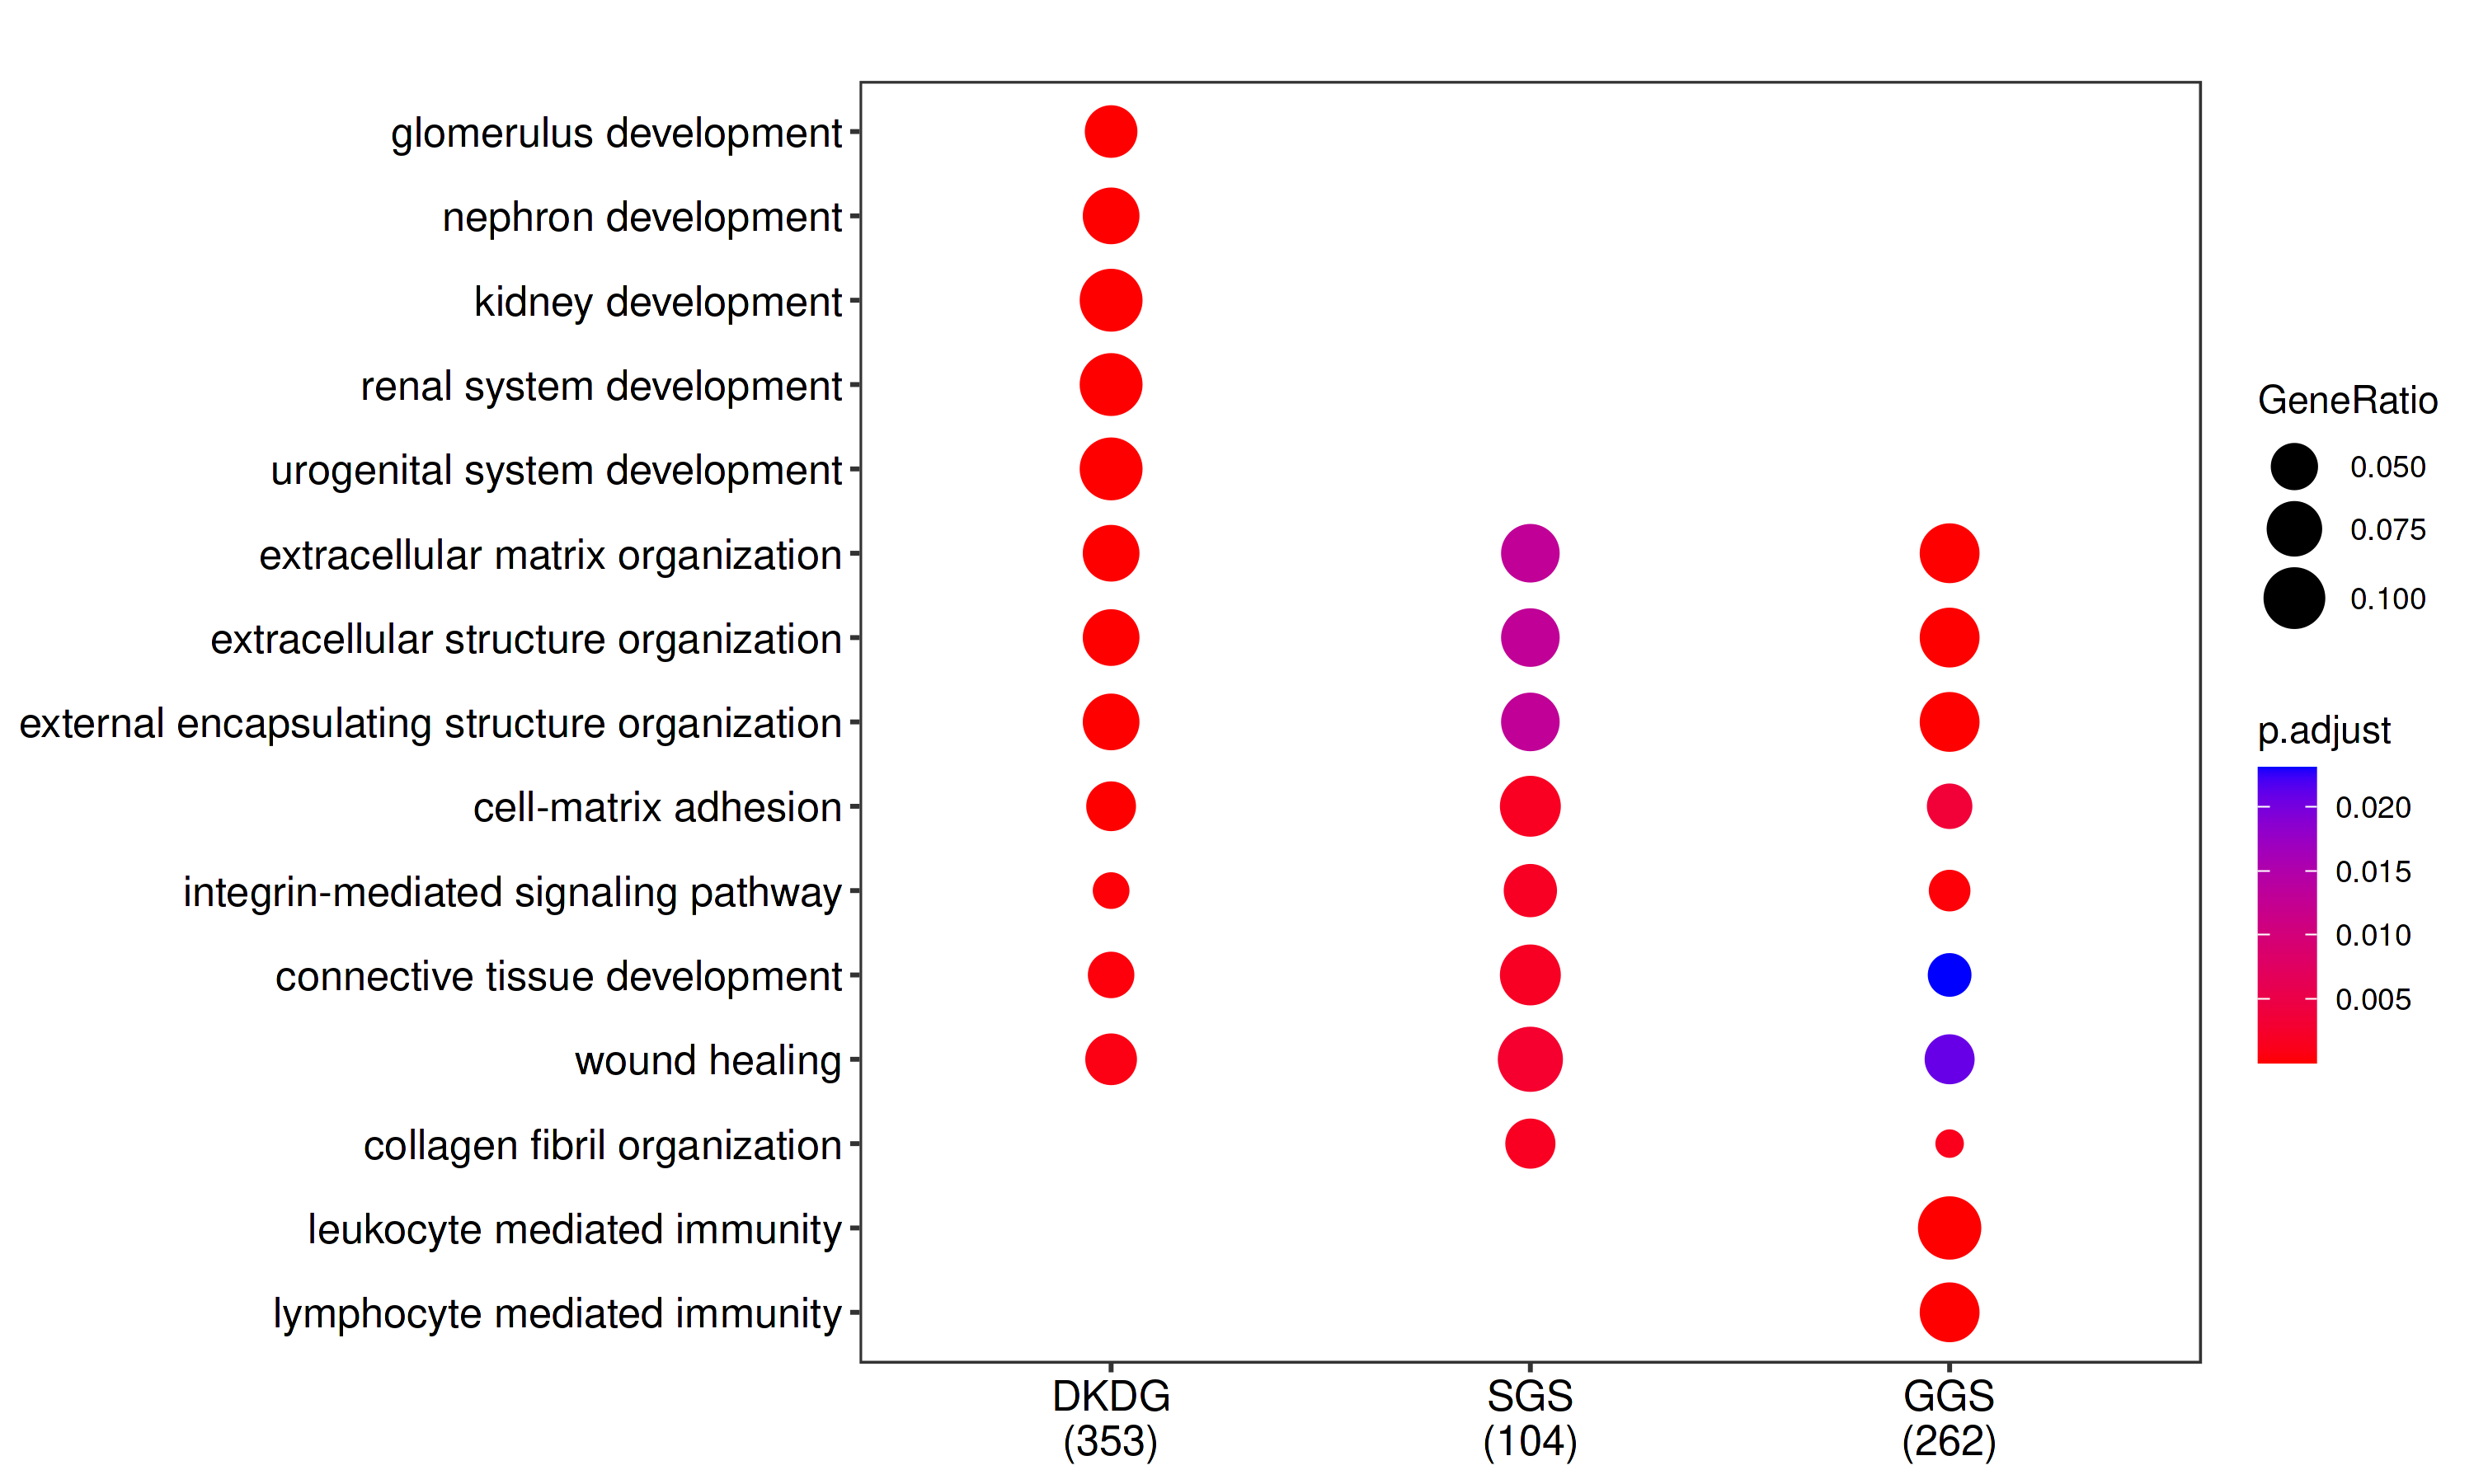

In [36]:
options(repr.plot.width = 10, repr.plot.height = 6, repr.plot.res = 300)
# Plot and visualise the data
p = dotplot(ck)
# adjust the size of y axis labels

p = p + scale_y_discrete(labels = wrap_format(100))
p = p + custom_theme +
#   xlab("Morph-based Glomeruli Subcluster") + 
theme(
    axis.title.x = element_blank(),
#     axis.title.x = element_text(face="bold"), 
      panel.grid.major = element_blank(),
    panel.grid.minor = element_blank() 
)
p

ggsave(file.path(plots_path_main, "ORA_DotPlot_glom_avg.png"), plot = p, width = 10, height = 6, units = "in", dpi = 300)
ggsave(file.path(plots_path_main, "ORA_DotPlot_glom_avg.pdf"), plot = p, width = 10, height = 6, units = "in", dpi = 300)
ggsave(file.path(plots_path_main, "ORA_DotPlot_glom_avg.svg"), plot = p, width = 10, height = 6, units = "in", dpi = 300)

### Step 7. Generate ridgeplot

In [37]:
feature_list = c('NPHS1', "COL1A2", "C1QB")

for (individual_feature in feature_list){
    p = RidgePlot(object = dkd1_glom_avg, features = individual_feature, cols = color_palette_glom)
    p = p + empty_theme + custom_theme + theme(legend.position = "None", panel.grid.major = element_blank(),
    panel.grid.minor = element_blank()) 
    
    ggsave(file.path(plots_path_main, paste0("RidgePlot_glom_avg_", individual_feature, ".png")), plot = p, width = 3, height = 6, units = "in", dpi = 300)
    ggsave(file.path(plots_path_main, paste0("RidgePlot_glom_avg_", individual_feature, ".pdf")), plot = p, width = 3, height = 6, units = "in", dpi = 300)
    ggsave(file.path(plots_path_main, paste0("RidgePlot_glom_avg_", individual_feature, ".svg")), plot = p, width = 3, height = 6, units = "in", dpi = 300)

}



Picking joint bandwidth of 0.158

Picking joint bandwidth of 0.158

Picking joint bandwidth of 0.158

Picking joint bandwidth of 0.229

Picking joint bandwidth of 0.229

Picking joint bandwidth of 0.229

Picking joint bandwidth of 0.141

Picking joint bandwidth of 0.141

Picking joint bandwidth of 0.141



### Step 8. Generate gene expression DoHeatmap

### Step 8. use complex heatmap instead of DoHeatmap because it mixed the identity groups in Seurat V4.

In [38]:
Idents(dkd1_glom_avg) = dkd1_glom_avg$glom_class

In [39]:
features = unlist(TopFeatures(dkd1_glom_avg[["pca"]], balanced = TRUE, dim = 1, nfeatures = 30))
df_plot = dkd1_glom_avg@assays$Spatial@scale.data[features, ]

identities = dkd1_glom_avg@meta.data$glom_class
desired_order <- c("DKDG", "SGS", "GGS")

identity_factor <- factor(identities, levels = desired_order)
ordered_identity = identity_factor[order(identity_factor)]

df_plot <- df_plot[, order(identity_factor)]

png 
  2

png 
  2

png 
  2

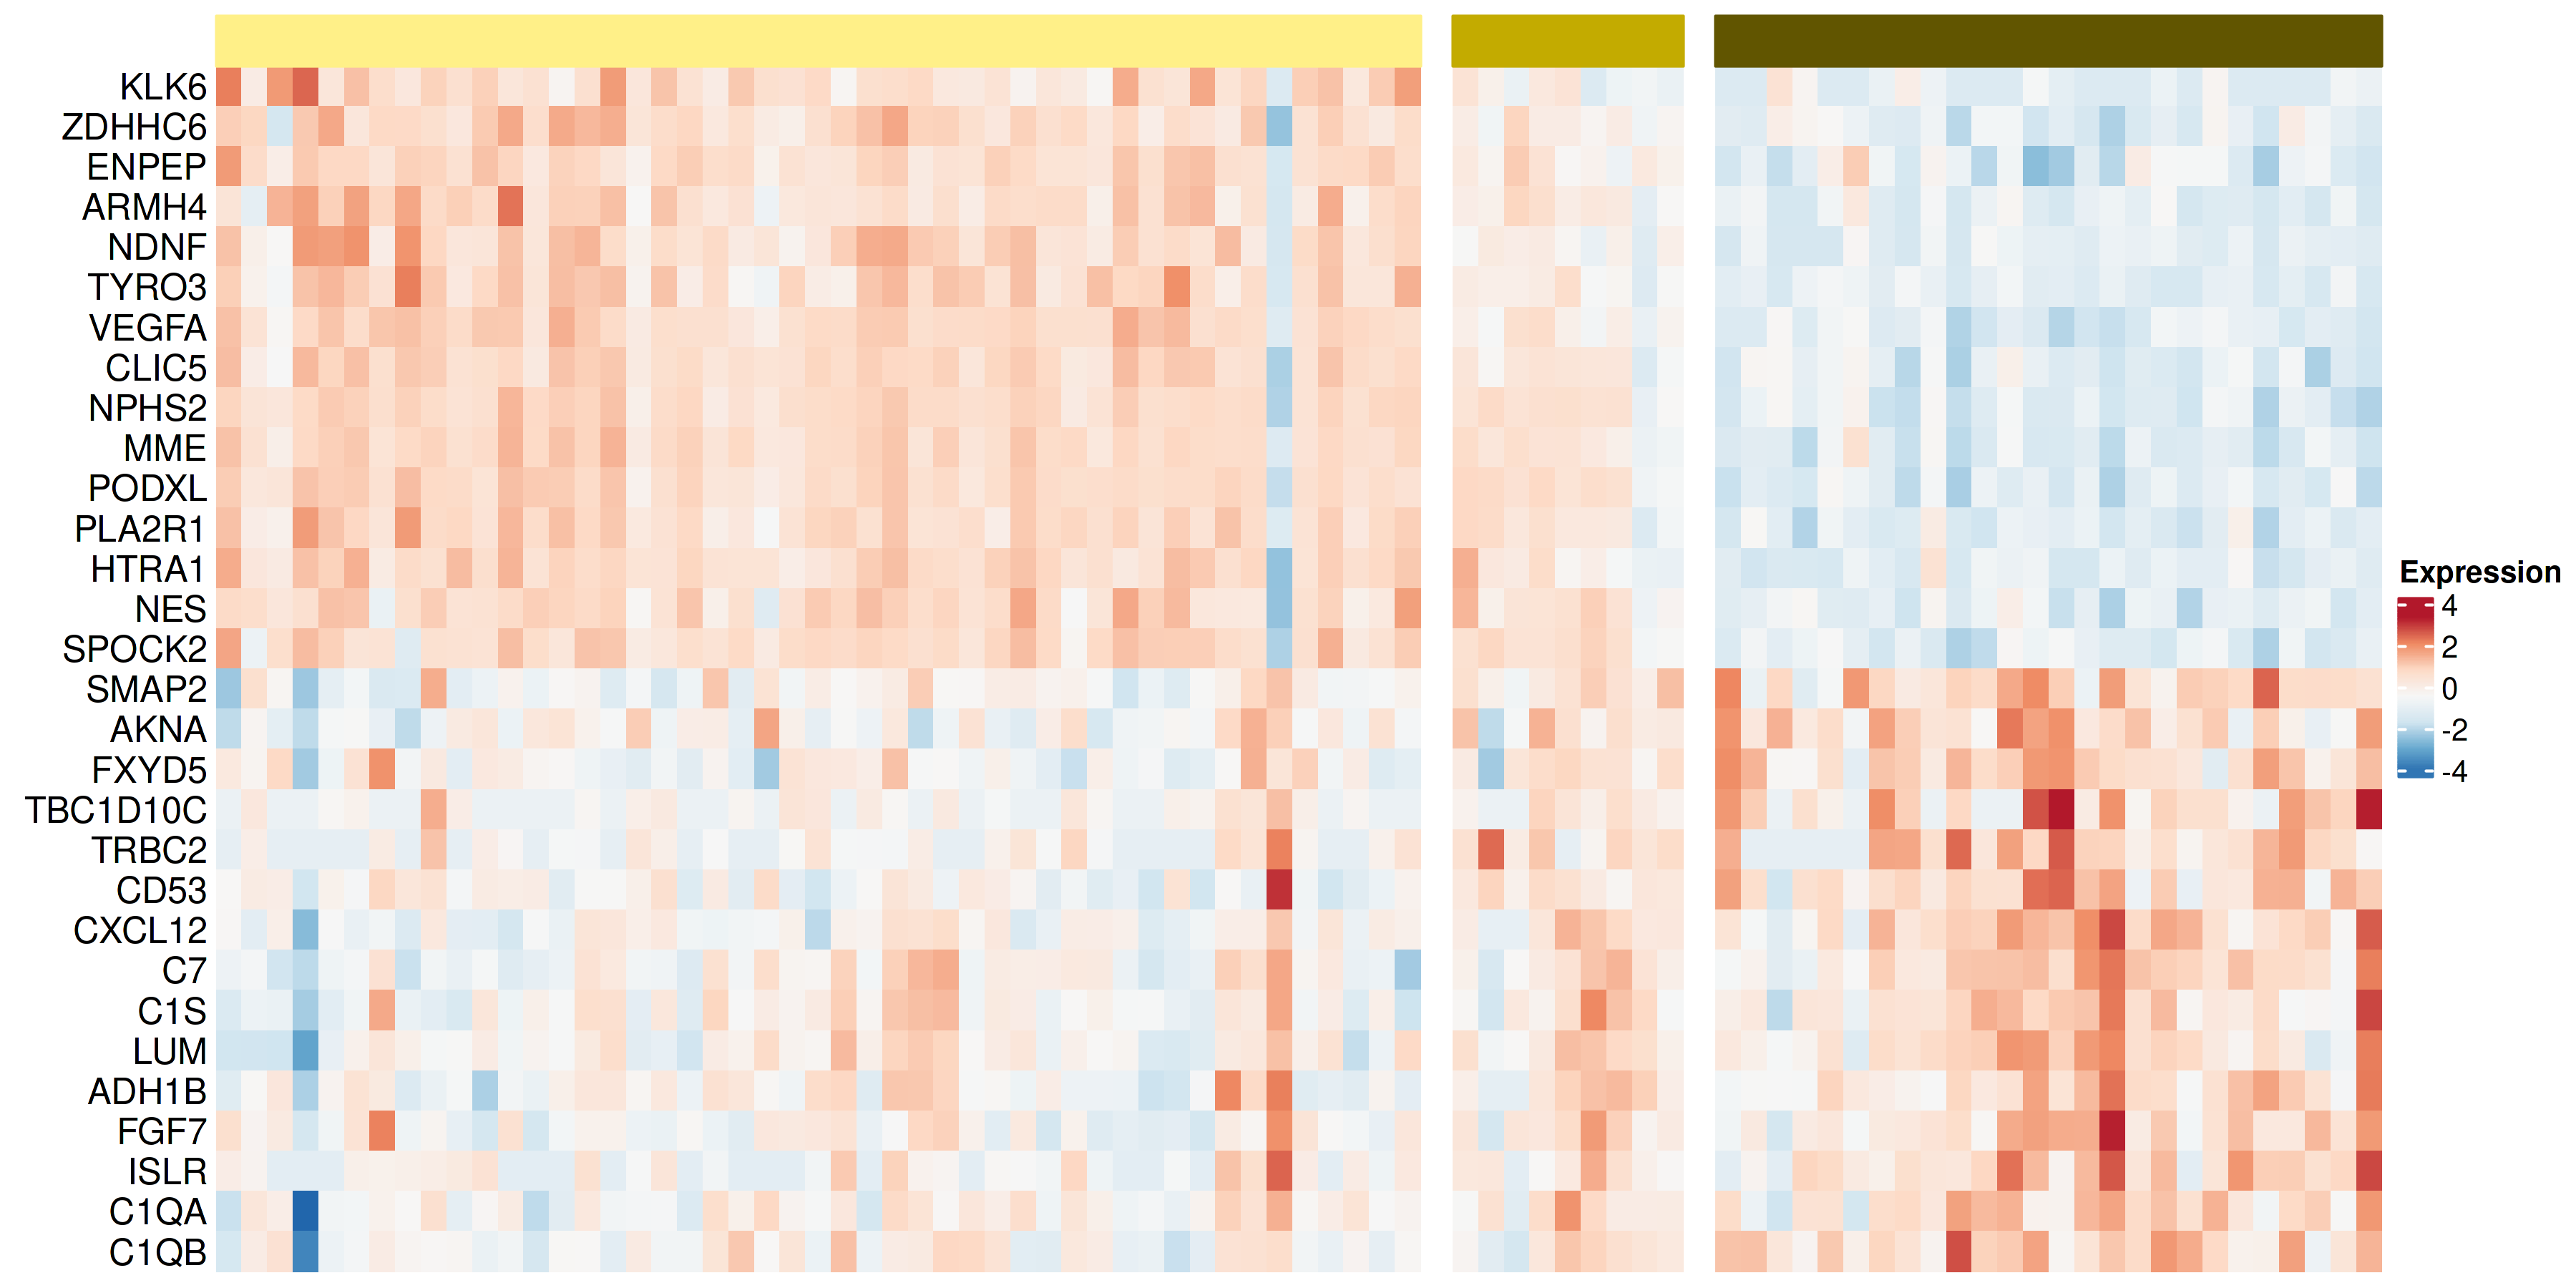

In [40]:
options(repr.plot.width = 12, repr.plot.height = 6, repr.plot.res = 300)

color_ht = colorRampPalette(rev(brewer.pal(n = 7, name = "RdBu")))(100)

pushViewport(viewport(gp = gpar(fontfamily = "Helvetica")))
# Creating the heatmap
p = Heatmap(df_plot, 
        name = "Expression", 
        column_split = ordered_identity,
            column_title_gp = gpar(fill = color_palette_glom, col = color_palette_glom),
            col = color_ht,
           show_row_dend = FALSE,
           show_column_dend = FALSE,
           row_names_side = "left",
           column_gap = unit(0.15, "in"), 
            cluster_columns = FALSE,
           show_column_names = FALSE)
p = p + gpar(fontfamily = "Helvetica", fontsize = 10)
p

png(file.path(plots_path_main, "Heatmap_glom_avg.png"), width = 12, height = 6, units = "in", res = 300)
draw(p)
dev.off()

pdf(file.path(plots_path_main, "Heatmap_glom_avg.pdf"), width = 12, height = 6)
draw(p)
dev.off()

svg(file.path(plots_path_main, "Heatmap_glom_avg.svg"), width = 12, height = 6)
draw(p)
dev.off()

### Step 9. DEG analysis for GGS vs. DKDG

In [41]:
Idents(dkd1_glom) = "glom_class"

In [42]:
deg = FindMarkers(dkd1_glom_avg, ident.1 = "GGS", ident.2 = "DKDG", only.pos = TRUE)

In [43]:
head(deg)

,p_val,avg_log2FC,pct.1,pct.2,p_val_adj
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
CLEC2D,1.475798e-08,0.4901428,1.000,0.851,0.0002668982
FGD3,4.417772e-08,0.4198551,0.923,0.511,0.0007989540
GPR34,6.723331e-08,0.4967034,1.000,0.872,0.0012159145
LCP1,4.943807e-07,0.6136037,1.000,0.936,0.0089408742
GZMA,5.972115e-07,0.2558462,0.731,0.213,0.0108005706
STAB1,8.451193e-07,0.5528433,1.000,0.979,0.0152839818


In [44]:
gene_list = rownames(deg)[deg$p_val < 0.001]
# gene_list = rownames(deg)
ids <- bitr(gene_list, fromType = 'SYMBOL', toType = c('SYMBOL', 'ENTREZID'), OrgDb = 'org.Hs.eg.db')
ids = ids$ENTREZID
length(ids)

'select()' returned 1:1 mapping between keys and columns



[1] 139

In [45]:
# Enrichment analysis with enrichGO Biological Process (BP)
ego <- enrichGO(gene         = ids,
                 OrgDb         = org.Hs.eg.db,
                 keyType       = 'ENTREZID',
                 ont           = "BP",
                 pAdjustMethod = "BH",
                 pvalueCutoff  = 0.01,
                 qvalueCutoff  = 0.05)

Scale for y is already present.
Adding another scale for y, which will replace the existing scale.


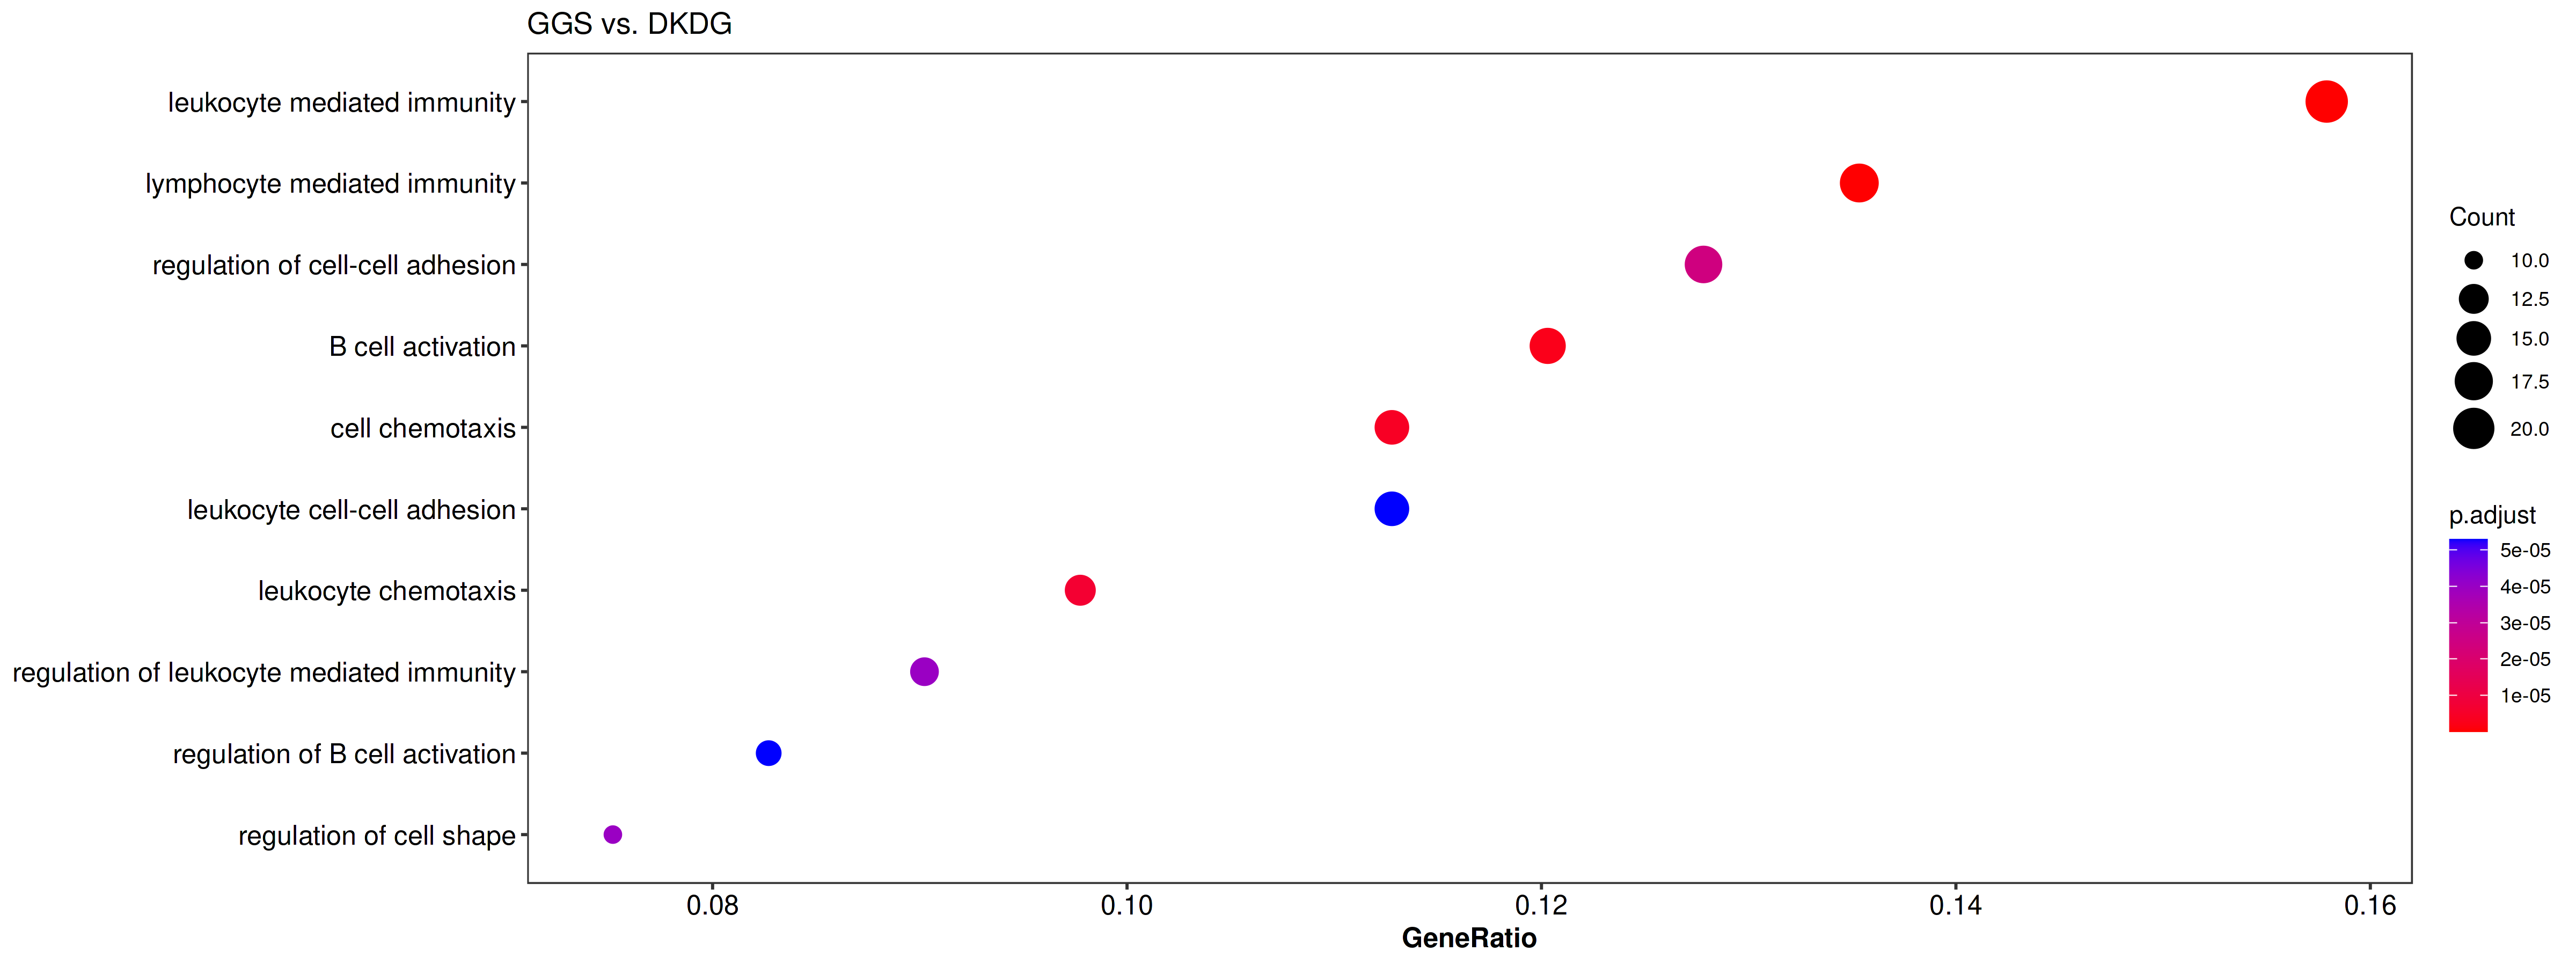

In [46]:
options(repr.plot.width = 16, repr.plot.height = 6, repr.plot.res = 300)
# Plot and visualise the data
p = dotplot(ego)
# adjust the size of y axis labels

p = p + scale_y_discrete(labels = wrap_format(100))
p = p + custom_theme +
theme(axis.title.x = element_text(face="bold"), 
      panel.grid.major = element_blank(),
    panel.grid.minor = element_blank()
) + ggtitle("GGS vs. DKDG")
p

ggsave(file.path(plots_path_supp, "ORA_DotPlot_glom_avg_GGS_vs_DKDG.png"), plot = p, width = 8, height = 6, units = "in", dpi = 300)
ggsave(file.path(plots_path_supp, "ORA_DotPlot_glom_avg_GGS_vs_DKDG.pdf"), plot = p, width = 8, height = 6, units = "in", dpi = 300)
ggsave(file.path(plots_path_supp, "ORA_DotPlot_glom_avg_GGS_vs_DKDG.svg"), plot = p, width = 8, height = 6, units = "in", dpi = 300)

### Step 10. DEG analysis for SGS vs. DKDG

In [47]:
deg = FindMarkers(dkd1_glom_avg, ident.1 = "SGS", ident.2 = "DKDG", only.pos = TRUE)

gene_list = rownames(deg)[deg$p_val < 0.05]

ids <- bitr(gene_list, fromType = 'SYMBOL', toType = c('SYMBOL', 'ENTREZID'), OrgDb = 'org.Hs.eg.db')
ids = ids$ENTREZID
length(ids)

'select()' returned 1:1 mapping between keys and columns

Warning message in bitr(gene_list, fromType = "SYMBOL", toType = c("SYMBOL", "ENTREZID"), :
“0.55% of input gene IDs are fail to map...”


[1] 181

In [48]:
# Enrichment analysis with enrichGO Biological Process (BP)
ego2 <- enrichGO(gene         = ids,
                 OrgDb         = org.Hs.eg.db,
                 keyType       = 'ENTREZID',
                 ont           = "BP",
                 pAdjustMethod = "BH",
                 pvalueCutoff  = 0.01,
                 qvalueCutoff  = 0.05)

Scale for y is already present.
Adding another scale for y, which will replace the existing scale.


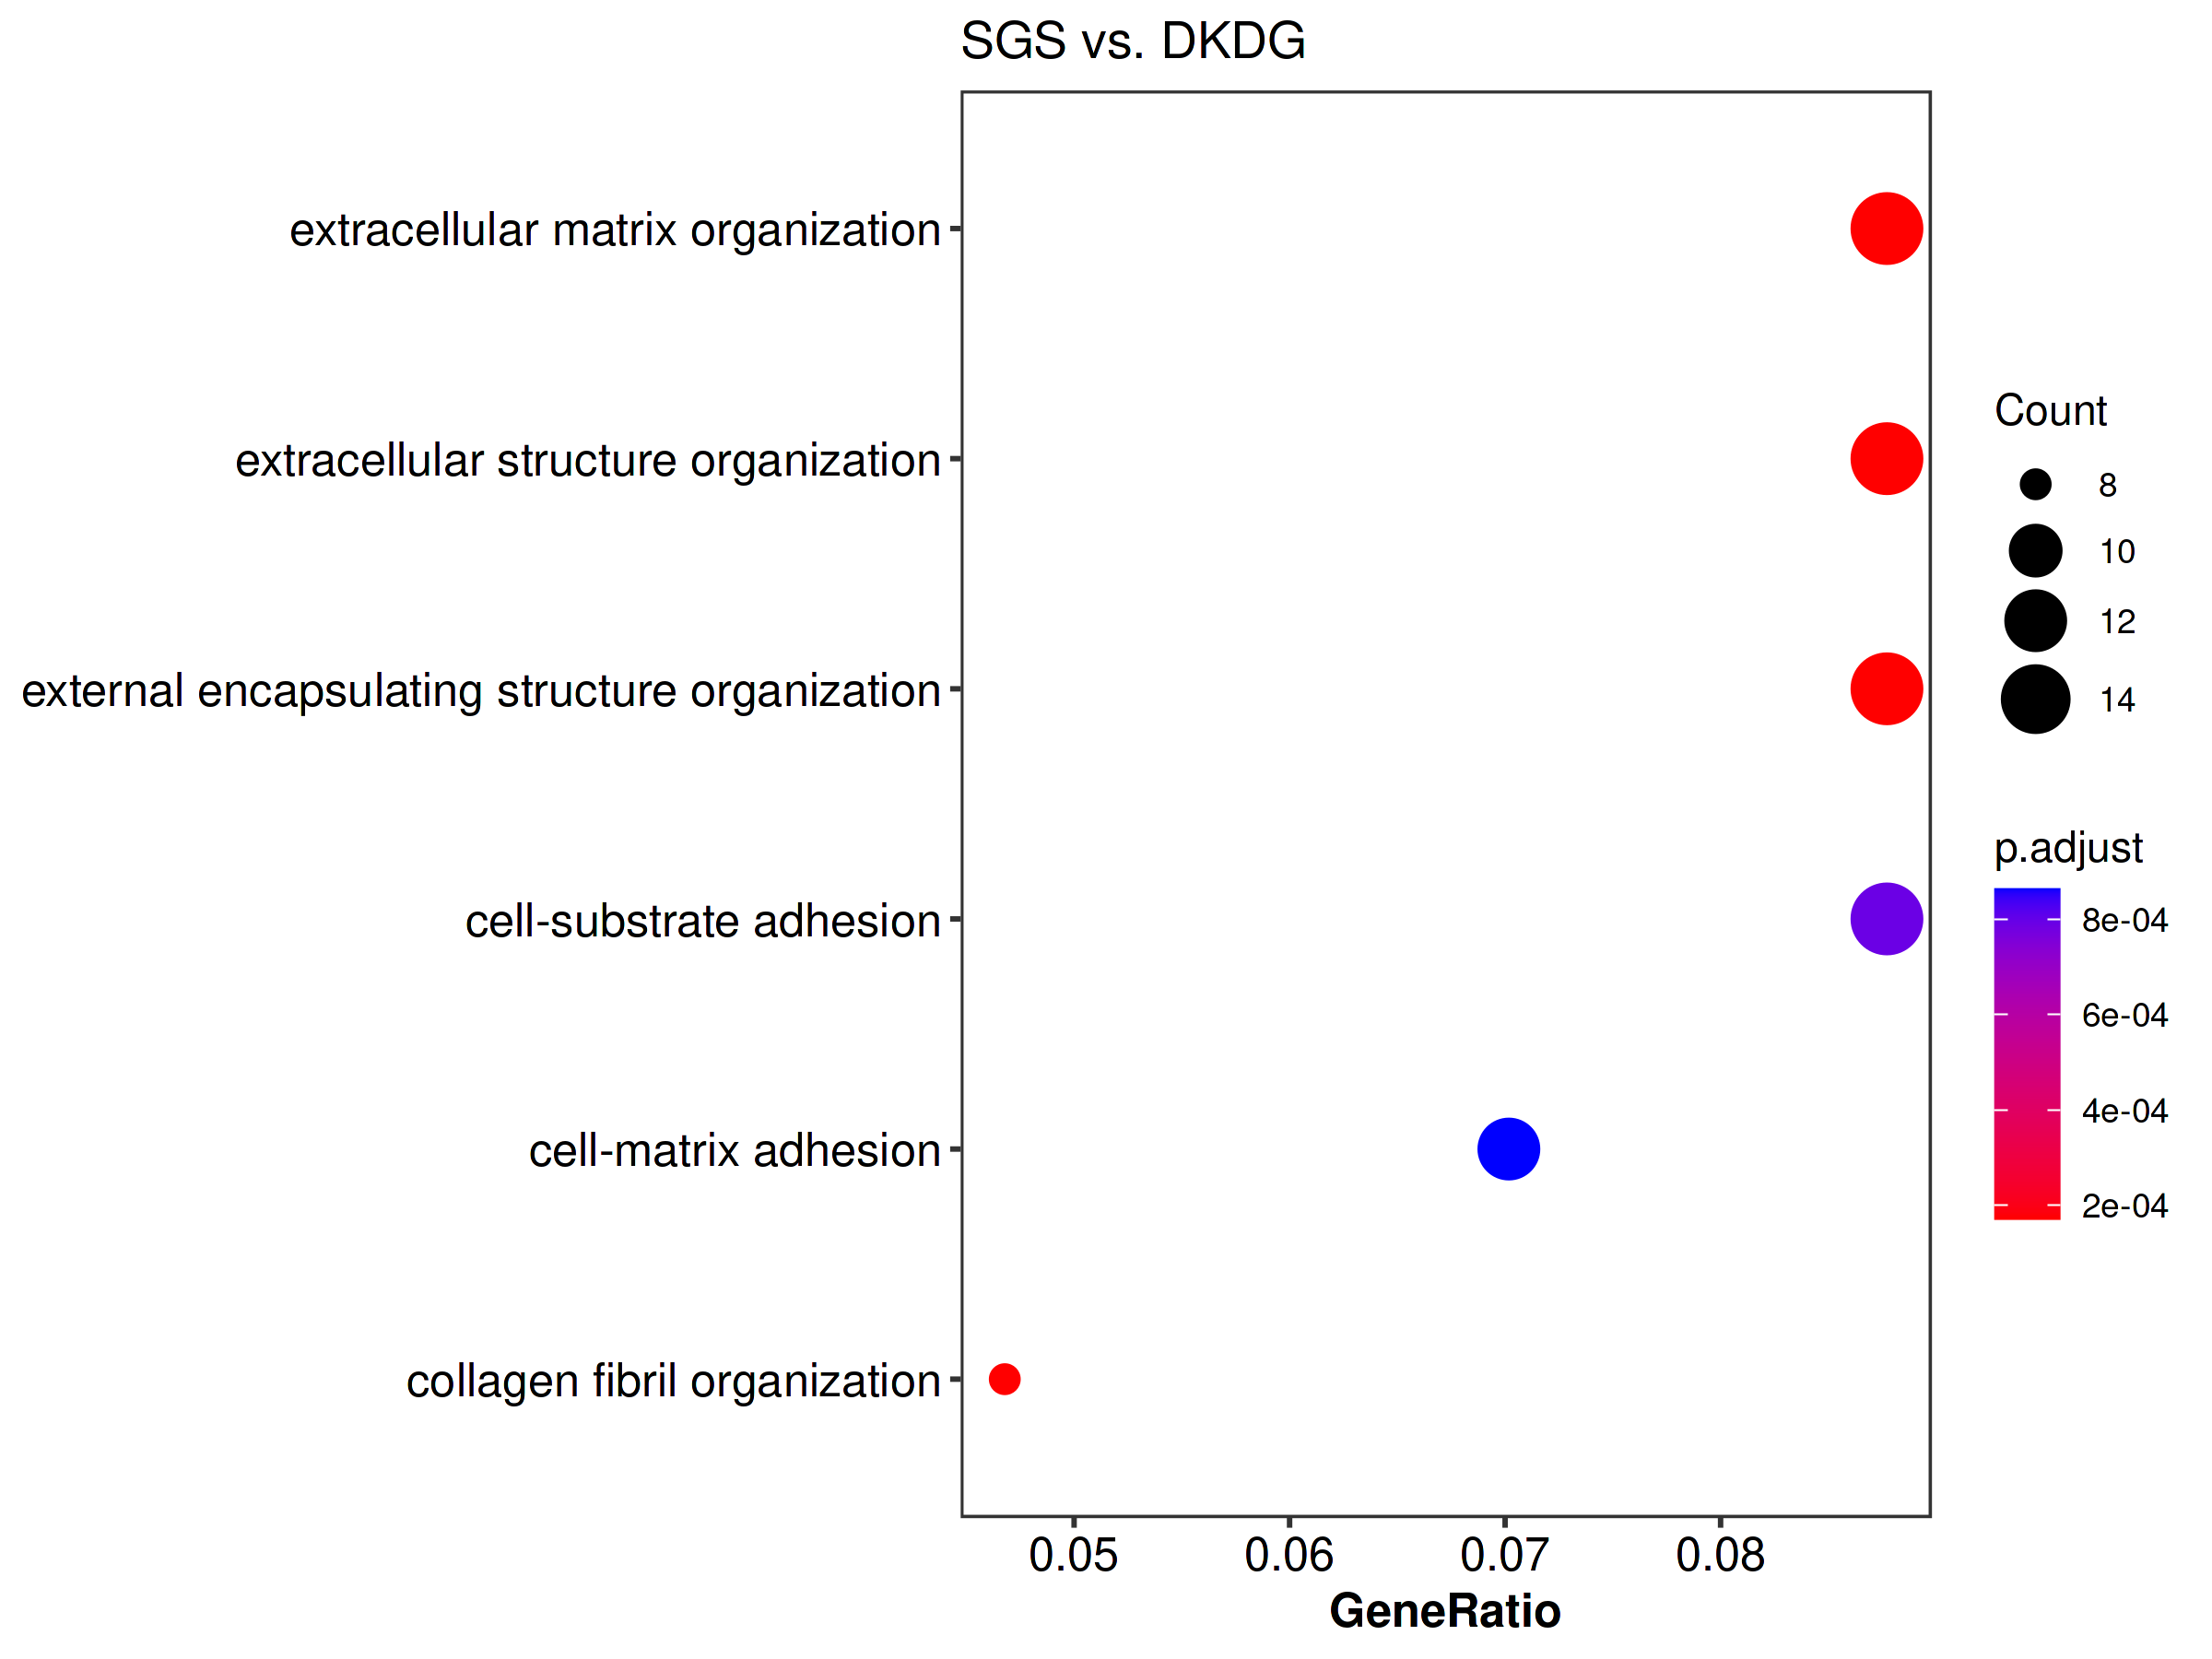

In [49]:
options(repr.plot.width = 8, repr.plot.height = 6, repr.plot.res = 300)
# Plot and visualise the data
p = dotplot(ego2)
# adjust the size of y axis labels

p = p + scale_y_discrete(labels = wrap_format(100))
p = p + custom_theme +
theme(axis.title.x = element_text(face="bold"), 
      panel.grid.major = element_blank(),
    panel.grid.minor = element_blank()
) + ggtitle("SGS vs. DKDG")
p

ggsave(file.path(plots_path_supp, "ORA_DotPlot_glom_avg_SGS_vs_DKDG.png"), plot = p, width = 8, height = 6, units = "in", dpi = 300)
ggsave(file.path(plots_path_supp, "ORA_DotPlot_glom_avg_SGS_vs_DKDG.pdf"), plot = p, width = 8, height = 6, units = "in", dpi = 300)
ggsave(file.path(plots_path_supp, "ORA_DotPlot_glom_avg_SGS_vs_DKDG.svg"), plot = p, width = 8, height = 6, units = "in", dpi = 300)

### Step 11. FindMarker for each of the Glomeruli subcluster compared to normal

#### Step 11.1 Change dkd1 idents to glom subcluters

In [50]:
Idents(dkd1) = df_meta$glom_class

In [51]:
df_meta_avg = df_meta
df_meta_avg$index = 1:dim(df_meta_avg)[1]
df_meta_avg$spot_id = paste0(df_meta_avg$glom_id, "_", df_meta_avg$index) 
df_meta_avg$spot_id[df_meta_avg$glom_id != "none"] = df_meta_avg$glom_id[df_meta_avg$glom_id != "none"]

dkd1_alt = dkd1
dkd1_alt$spot_id = df_meta_avg$spot_id
Idents(dkd1_alt) = "spot_id"

In [52]:
dkd1_alt_avg = AverageExpression(dkd1_alt, assays = "Spatial", slot="counts",return.seurat = T)

In [53]:
dkd1_alt_avg

An object of class Seurat 
18085 features across 2539 samples within 1 assay 
Active assay: Spatial (18085 features, 0 variable features)

In [54]:
meta_tmp = dkd1_alt_avg@meta.data
meta_tmp$glom_id = meta_tmp$orig.ident
meta_tmp$spot_id = rownames(meta_tmp)

meta_tmp = left_join(meta_tmp, distinct(df_meta_avg[, c("glom_id", "glom_class")]), by = "glom_id")
rownames(meta_tmp) = meta_tmp$spot_id
head(meta_tmp)

dkd1_alt_avg@meta.data = meta_tmp

,orig.ident,nCount_Spatial,nFeature_Spatial,glom_id,spot_id,glom_class
,<fct>,<dbl>,<int>,<chr>,<chr>,<chr>
none_1,none,37726.00,9197,none,none_1,none
G40,G40,17186.75,11380,G40,G40,DKDG
none_3,none,19244.00,7267,none,none_3,none
none_4,none,24380.00,8180,none,none_4,none
none_5,none,22432.00,8043,none,none_5,none
none_6,none,18935.00,7598,none,none_6,none


In [55]:
dkd1_alt_avg <- NormalizeData(dkd1_alt_avg, assay = "Spatial", verbose = FALSE)
dkd1_alt_avg <- FindVariableFeatures(dkd1_alt_avg, selection.method = "vst", nfeatures = 2000)
dkd1_alt_avg <- ScaleData(dkd1_alt_avg)

Centering and scaling data matrix



In [56]:
Idents(dkd1_alt_avg) = "glom_class"

In [57]:
df_markers <- FindAllMarkers(dkd1_alt_avg, only.pos = TRUE, min.pct = 0.1, return.thresh = 0.05)

Calculating cluster none

Calculating cluster DKDG

Calculating cluster GGS

Calculating cluster SGS



In [58]:
df_markers = df_markers[df_markers$cluster != "none", ]

In [59]:
write.csv(df_markers, file = file.path(processed_data_path, "markers_glom_avg_vs_other.csv"), row.names=F)

In [60]:
# Change genes name to entrezID
Cluster_df = df_markers
cluster_name_list = unique(Cluster_df$cluster)
cluster_name_list

ids_list = lapply(cluster_name_list, FUN = function(x){
  cluster_i <- Cluster_df[Cluster_df$cluster == x, ]
  ids <- bitr(cluster_i$gene, fromType = 'SYMBOL', toType = c('SYMBOL', 'ENTREZID'), OrgDb = 'org.Hs.eg.db')
  ids$ENTREZID
})
names(ids_list) = cluster_name_list

# Enrichment analysis with enrichGO Biological Process (BP)
ck <- compareCluster(geneCluster = ids_list, fun = enrichGO,
                     OrgDb = org.Hs.eg.db,
                     # keytype = 'ENTREZID',
                     ont = 'BP',
                     pAdjustMethod = 'BH',
                     pvalueCutoff = 0.05,
                     qvalueCutoff = 0.1)
ck <- setReadable(ck, OrgDb = org.Hs.eg.db, keyType="ENTREZID")

[1] DKDG GGS  SGS 
Levels: none DKDG GGS SGS

'select()' returned 1:1 mapping between keys and columns

Warning message in bitr(cluster_i$gene, fromType = "SYMBOL", toType = c("SYMBOL", :
“0.53% of input gene IDs are fail to map...”
'select()' returned 1:1 mapping between keys and columns

Warning message in bitr(cluster_i$gene, fromType = "SYMBOL", toType = c("SYMBOL", :
“1.63% of input gene IDs are fail to map...”
'select()' returned 1:1 mapping between keys and columns

Warning message in bitr(cluster_i$gene, fromType = "SYMBOL", toType = c("SYMBOL", :
“0.57% of input gene IDs are fail to map...”


Scale for y is already present.
Adding another scale for y, which will replace the existing scale.


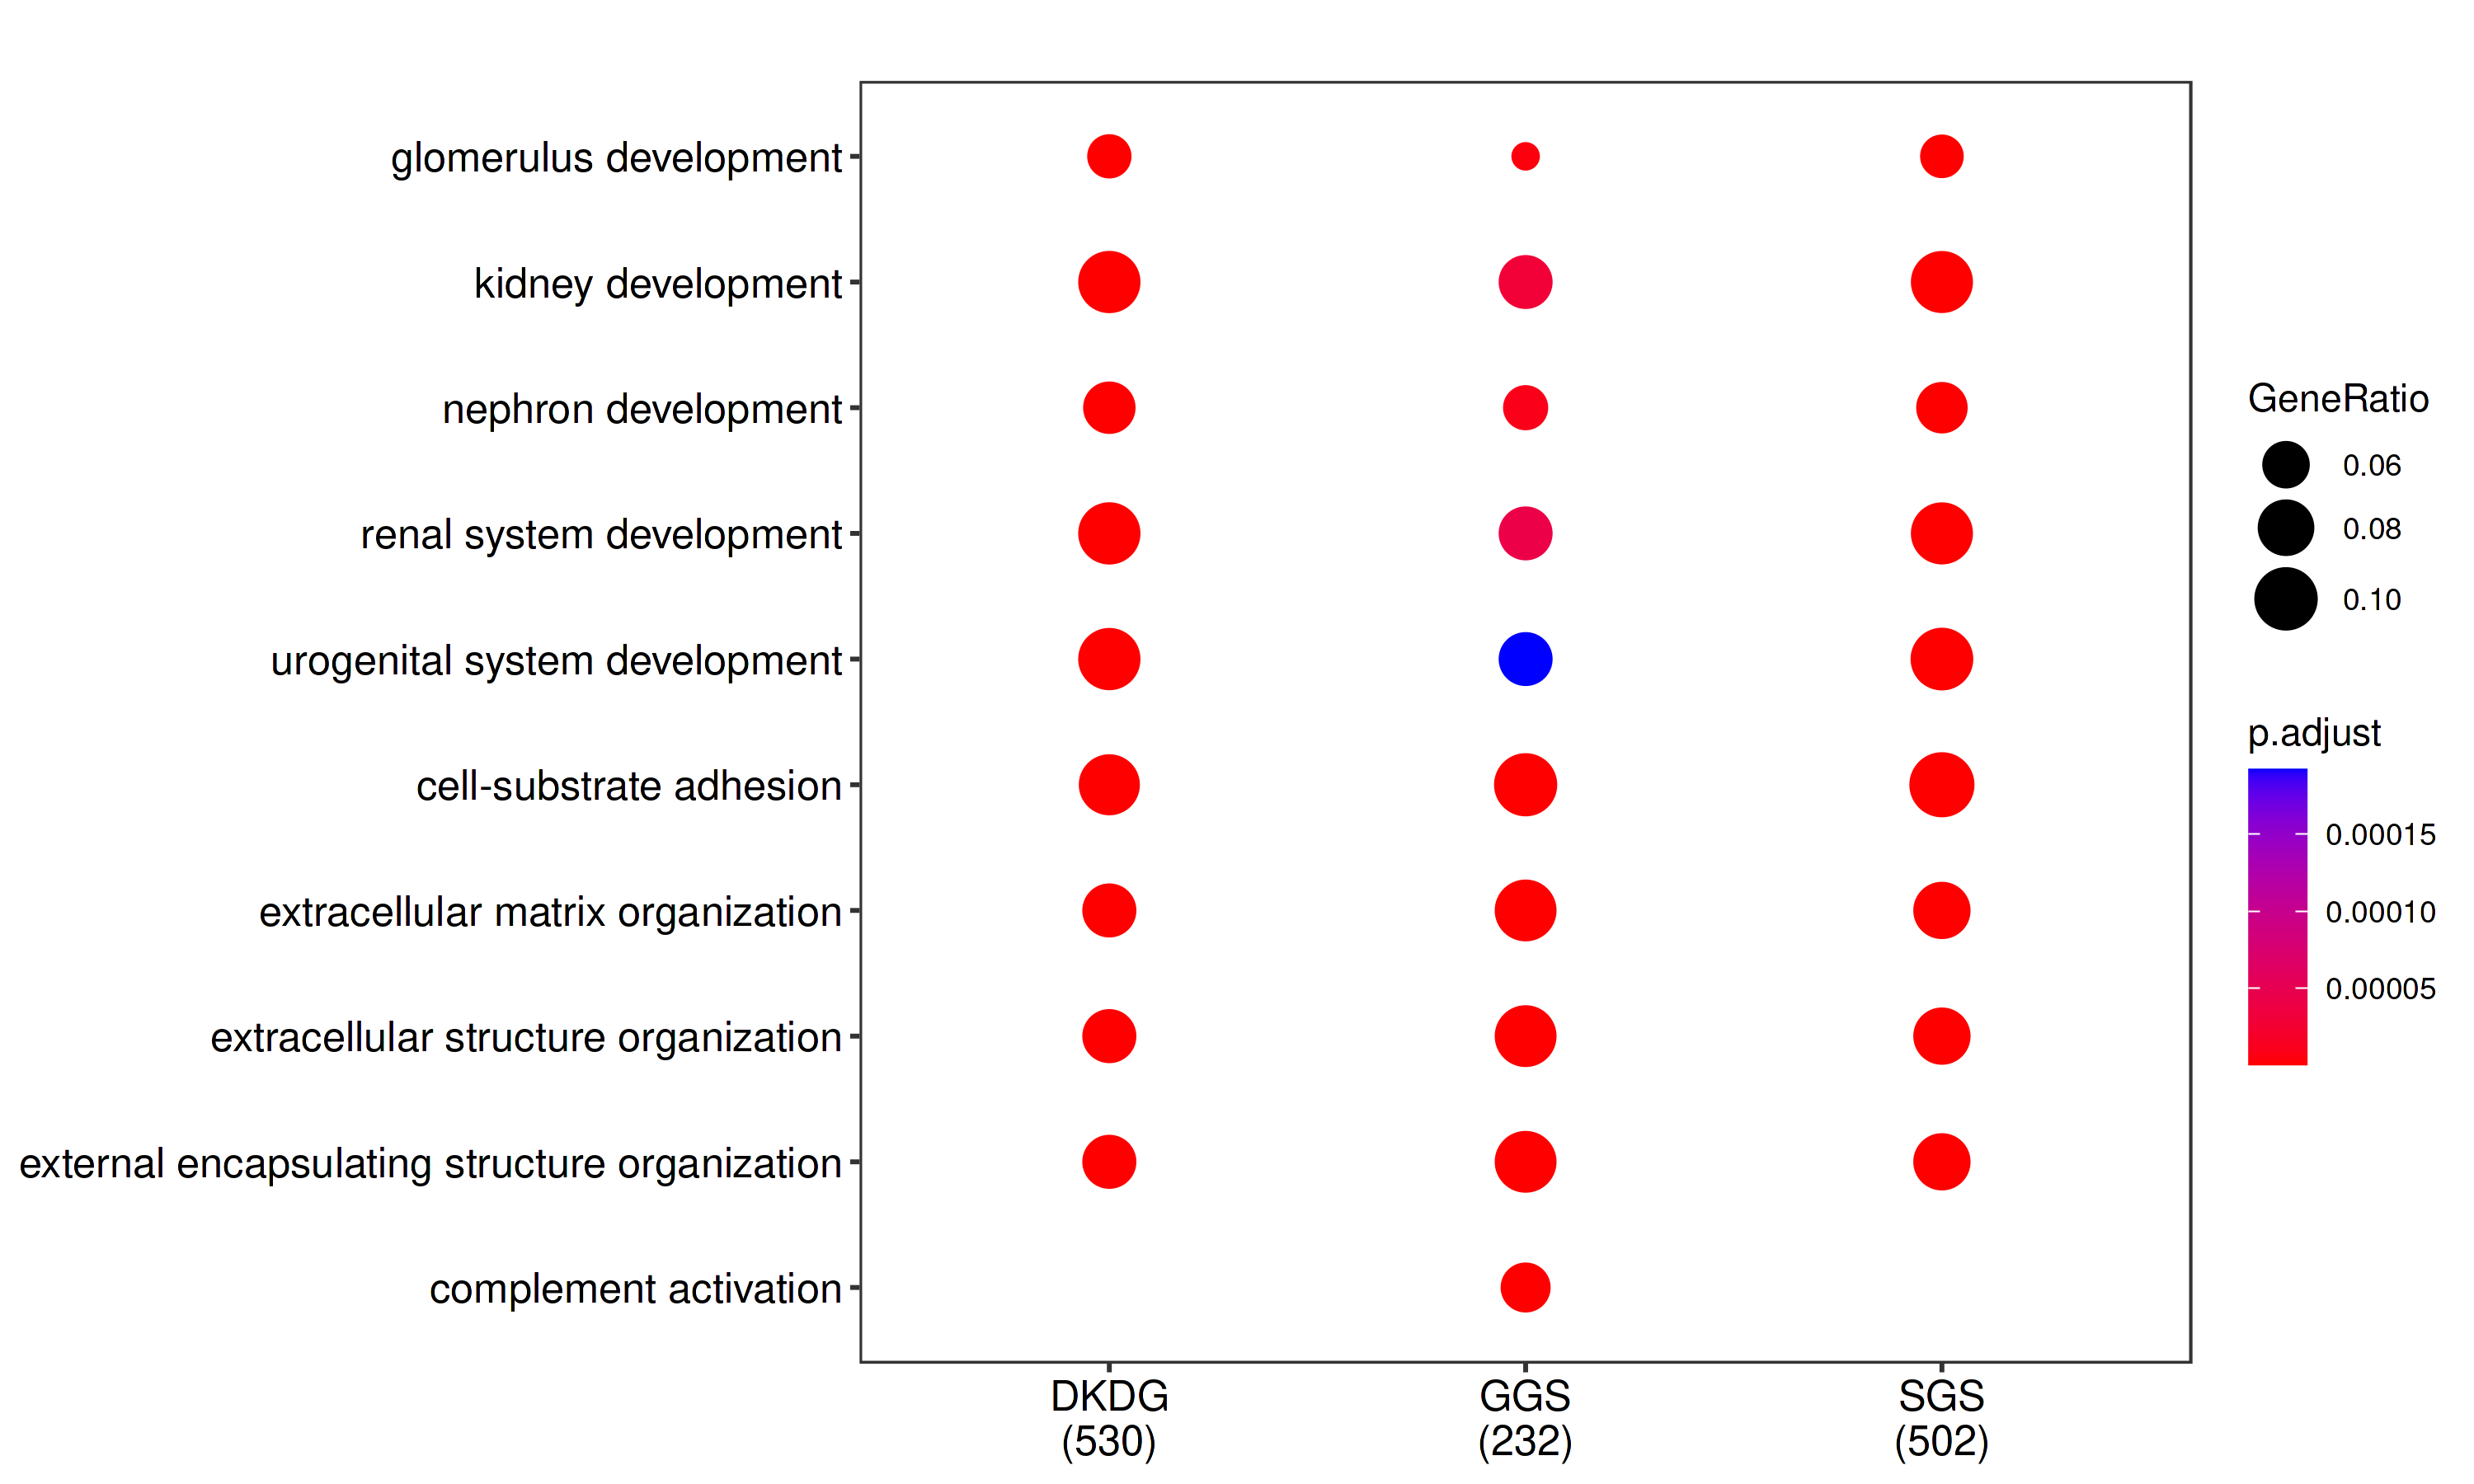

In [61]:
options(repr.plot.width = 10, repr.plot.height = 6, repr.plot.res = 300)
# Plot and visualise the data
p = dotplot(ck)
# adjust the size of y axis labels

p = p + scale_y_discrete(labels = wrap_format(100))
p = p + custom_theme +
#   xlab("Morph-based Glomeruli Subcluster") + 
theme(
    axis.title.x = element_blank(),
#     axis.title.x = element_text(face="bold"), 
      panel.grid.major = element_blank(),
    panel.grid.minor = element_blank() 
)
p

ggsave(file.path(plots_path_main, "ORA_DotPlot_glom_avg_vs_other.png"), plot = p, width = 10, height = 6, units = "in", dpi = 300)
ggsave(file.path(plots_path_main, "ORA_DotPlot_glom_avg_vs_other.pdf"), plot = p, width = 10, height = 6, units = "in", dpi = 300)
ggsave(file.path(plots_path_main, "ORA_DotPlot_glom_avg_vs_other.svg"), plot = p, width = 10, height = 6, units = "in", dpi = 300)

In [62]:
sessionInfo()

R version 4.2.2 (2022-10-31)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: Ubuntu 20.04.2 LTS

Matrix products: default
BLAS:   /usr/lib/x86_64-linux-gnu/blas/libblas.so.3.9.0
LAPACK: /usr/lib/x86_64-linux-gnu/lapack/liblapack.so.3.9.0

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats4    grid      stats     graphics  grDevices utils     datasets 
[8] methods   base     

other attached packages:
 [1] org.Hs.eg.db_3.16.0    AnnotationDbi_1.60.2   IRanges_2.32.0        
 [4] S4Vectors_0.36.2       Biobase_2.52.0         BiocGenerics_0.44.0   
 [7] clusterProfiler_4.6.2  gplots_3.1.1           scales_1.2.1          
[10] RColorBrewer_1.1-